# Prototyping the TRMF Regression algorithm

This notebook re-derives and implements the matrix factorization with
autoregressive regularizer for time-series latent factors from
> 
    .. [1] Yu, H. F., Rao, N., & Dhillon, I. S., (2016). "Temporal
           regularized matrix factorization for high-dimensional time
           series prediction." In Advances in neural information processing
           systems (pp. 847-855).

In [ ]:
import numpy as np
import pandas as pd

import networkx as nx

import numba as nb

%matplotlib inline
import matplotlib.pyplot as plt

import tqdm

from itertools import chain

from sklearn.utils.extmath import safe_sparse_dot

import scipy.sparse as sp

Let's import some stuff copied from my library `SGIMC` for matrix completion

In [ ]:
from trmf.tron import tron

<br>

### Generating synthetic dataset

In [ ]:
random_state = np.random.RandomState(8945634)

# n_samples, n_components, n_targets, n_order = 120, 4, 16, 8
n_samples, n_components, n_targets, n_order = 128, 4, 16, 5

Generate coefficients of a stationary lag polynomial of order $p$. For explanation and derivations related to the synthetic dataset generator refer to `trmf_synthetic_example.ipynb`.

In [ ]:
rad = random_state.uniform(0, 1.01, size=(n_components, n_order))
phi = random_state.uniform(0, 2, size=(n_components, n_order)) * np.pi

phi /= 4  # confine the roots to the upper left quadrant

roots = np.sqrt(rad) * (np.cos(phi) + np.sin(phi) * 1.j)

n_cplx = max(0, n_order - 1) // 2
n_real = n_order - n_cplx * 2

roots = np.concatenate([
    roots[:, :n_cplx], np.conj(roots[:, :n_cplx]), np.real(roots[:, -n_real:])
], axis=-1)

real_phi = np.stack([- np.poly(zeroes)[1:] for zeroes in roots], axis=0)
real_ar_coef = real_phi[:, ::-1].copy()

Let's make sure the roots are within the unit circle.

In [ ]:
colors = np.array([[c] * n_order for c in ["C0", "C1", "C2", "C3"]]).ravel()

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="polar")
ax.scatter(np.angle(roots), np.abs(roots), c=colors, s=50)  #, c=colors, s=area, cmap='hsv', alpha=0.75)
ax.set_rlim(0, 1.1)
plt.show()

Simulate the autoregressive process.

In [ ]:
noise = random_state.normal(scale=0.1, size=(n_samples, n_components))
for t in range(n_order, n_samples):
    noise[t] += np.einsum("il,li->i", real_ar_coef, noise[t-n_order:t])
#     noise[t] = np.einsum("il,li->i", real_ar_coef, noise[t-n_order:t])

real_factors = noise.copy()

Plot the factors

In [ ]:
n_cols = 3
n_rows = (n_components + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 1.5*n_rows),
                         sharex=True, sharey=False)
for j, ax in zip(range(n_components), axes.ravel()):
    ax.plot(real_factors[:, j])

plt.show()
plt.close()

Generate factor loadings

In [ ]:
real_loadings = random_state.uniform(-1, 2, size=(n_components, n_targets))
real_loadings  = np.maximum(real_loadings, 0)

noise = random_state.normal(scale=0.1, size=(n_samples, n_targets))

targets = np.dot(real_factors, real_loadings) + noise

In [ ]:
n_cols = 3
n_rows = (n_targets + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 1.5*n_rows), sharex=True, sharey=False)
for j, ax in zip(range(n_targets), axes.ravel()):
    ax.plot(targets[:, j], lw=2)
    ax.set_title(f"""target {j}""")

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(real_loadings, cmap=plt.cm.hot)

In [ ]:
plt.plot(np.linalg.norm(real_loadings, ord=1, axis=0))

<br>

# Matrix Factorization with time series structure

Consider a (directed) graph $G$ representing the **`is a component of`** binary relation
on targets: for an y$u \in G $ the fact that $v \in G_u$ means that $u$ is required
to produce $v$. The weighted adjacency matrix $A$ is given by $A_{uv} = \sigma_{uv}
1_{G_u}(v)$, where $\sigma_{uv} = \sigma(v\to u)$ is the conversion
rate from units of $v$ back to units of $u$.

For example, $\sigma(v\to u)$ might represent minimial volume of input $u$ required
to produce one unit of $v$ in the latter's production function.

**NOTE** that $\lvert G_u \rvert$ counts the number of neighbours of $u$ according the relation.

<br>

We use the [TRMF](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf) model.
Let's consider the following matrix decomposition for $Y$ -- $T\times n$ matrix
of multivariate time series:
$$
    \min_{F, Z, \phi}
        \tfrac1{2 T n} \|Y - Z F \|^2_2
        + \tfrac{\lambda_F}2 \mathcal{R}_F(F \mid G)
        + \tfrac{\lambda_Z}2 \mathcal{R}_Z(Z \mid\, p, \phi)
        + \tfrac{\lambda_\phi}2 \mathcal{R}_\phi(\phi)
\,, $$
where $Z$ is $T \times d$ matrix of the time-series of $d$ latent factors and
$F$ is the $d \times n$ matrix of factor loadings.

<br>

## Regularizers

The regularizers are:
\begin{align}
\mathcal{R}_\phi(\phi)
    &= \tfrac1{d p} \|\phi\|^2_F
    \,, \\
\mathcal{R}_F(F\mid\, G)
    &= (1 - \eta_{FG} - \eta_{FN}) \tfrac1{d n} \|F\|^2_F
    + \eta_{FN} \overbrace{\iota_{\mathbb{R}_+^{d\times n}}(F)}^{\text{non-negativity}}
    + \eta_{FG} \tfrac1{n} \sum_{u\in G}
        \overbrace{
             \tfrac1{d} \Bigl\|F e_u - \tfrac1{\lvert G_u\rvert} \sum_{v \in G_u} F e_v A_{uv} \Bigr\|^2
        }^{\text{downstream tightness}}
    \,, \\
\mathcal{R}_Z(Z \mid\, p, \phi)
    &= (1 - \eta_Z) \tfrac1{T d} \|Z\|^2_F
    + \eta_Z \tfrac1{d} \sum_{j=1}^d
        \overbrace{
            \tfrac1{T-p} \sum_{t=p+1}^T \bigl( Z^j_t - \sum_{i=1}^p \phi_{ji} Z^j_{t-i} \bigr)^2
        }^{AR(p) \, \text{forcastible factors}}
    \,,
\end{align}
where $\phi$ is $d \times p$ matrix of AR coefficients, related $\eta$'s sum to $1$
and are nonnegative and $Z^j_t = Z_{jt}$.

Since $A_{uv}$ is nonzero only if $v \in G_u$, the `downstream tightness` regularizer
simplifies to
\begin{equation}
\ldots
    = \sum_{u\in G} \bigl\|F e_u - \sum_{v \in G}
        F e_v e_v^{\mathrm{T}} A^{\mathrm{T}} e_u \tfrac1{\lvert G_u\rvert} \bigr\|^2
    = \sum_{u\in G} \bigl\|F e_u - F A^{\mathrm{T}} D^{-1} e_u \bigr\|^2
    = \sum_{u\in G} \bigl\|F (I - A^{\mathrm{T}} D^{-1}) e_u\bigr\|^2
    = \bigl\| F (I - A^{\mathrm{T}} D^{-1}) \bigr\|^2_F
    \,,
\end{equation}
where $D = \mathop{\mathrm{diag}}(\lvert G_u \rvert)_{u\in G}$ is the out-degree matrix of $G$.

Another possible graph regularizer, which dominates the one above if $G$ is
an undirected graph, is `pairwise tightness`
\begin{align}
\sum_{u \in G}\sum_{v\in G_u} \tfrac12 \|F e_u - F e_v\|^2
    &= \tfrac12 \sum_{u,v \in G} A_{uv} \|F e_u - F e_v\|^2
    = \tfrac12 \sum_{u,v \in G} A_{uv} \|F e_u\|^2
        + A_{uv} \|F e_v\|^2
        - 2 e_u^{\mathrm{T}} F^{\mathrm{T}} F e_v A_{uv}
    \\
    &= \sum_{u \in G} \|F e_u\|^2 \sum_{v \in G} \tfrac12 (A_{uv} + A_{vu})
        - \sum_{u,v \in G} e_v^{\mathrm{T}} F^{\mathrm{T}} F e_u A_{uv}
    \\
    &= \mathop{\mathrm{tr}} \biggl(
        F \Bigl( \sum_{u \in G} e_u \delta_u e_u^{\mathrm{T}} \Bigr) F^{\mathrm{T}}
        - F \Bigl( \sum_{u,v \in G} e_u A_{uv} e_v^{\mathrm{T}} \Bigr) F^{\mathrm{T}}
    \biggr)
    = \mathop{\mathrm{tr}} \bigl(
        F \underbrace{( D - A )}_{\mathcal{L}} F^{\mathrm{T}}
    \bigr)
\end{align}
where $A$ is the symmetric weighted adjacency matrix of the graph $G$ (or
a binary matrix if the edges of $G$ are unweighted) and $\delta_u = \sum_{v \in G} A_{uv}$.

<br>

### $AR(p)$-regularizer

Let's re-derive theorem 1 from [[Yu, Rao, Dhillon; 2016]](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf),
which reduces the AR regularizer to a graph-like regularizer. However, this time instead
of the explicit lag structure of the AR, let's consider full AR$(p)$: no generality is lost,
since we can impose the lag structure implicitly via force zeroeing in the AR polynomial
coefficients).

#### Computing $AR(p)$ for a single series

Consider a series $z = (z_\tau)_{\tau=1}^T$ and AR$(p)$ coefficients $(\beta_k)_{k=0}^p$,
with $\beta_0 = -1$. Sparse lag structure $L \subseteq \{1,\,\ldots,\, p\}$ is imposed by
forcing $\beta_k = 0$ for any $k \notin L$.

The AR$(p)$ residuals for series $z$ for given AR coefficients $\beta$ is:
\begin{equation}
r_t(z)
    = \sum_{k=0}^p \beta_k z_{t-k}
    = z_t - \sum_{k=1}^p \beta_k z_{t-k}
    = z_t - \beta_1 z_{t-1} - \cdots - \beta_p z_{t-p}
    \,,
\end{equation}
for $t=p+1,\,\ldots,\, T$.

**NOTE** The $\beta = \phi_j$ is in little endian lag order: $\beta_i$, $i=1..p$,
corresponds to lag $p-i+1$. Also $z_{i:T+1-p+i}$ is the $p-i+1$ lagged slice of the series.

In [ ]:
@nb.njit("float64[:,::1](float64[:,::1], float64[:,::1])",
         fastmath=True, cache=False, error_model="numpy")
def ar_resid(Z, phi):
    n_components, n_order = phi.shape

    # compute the AR(p) residuals
    resid = Z[n_order:].copy()
    for k in range(n_order):
        # r_t -= y_{t-(p-k)} * \beta_{p - k} (phi is reversed beta)
        resid -= Z[k:k - n_order] * phi[:, k]

    return resid

<br>

#### $AR(p)$ regualrizer  as a quadratic form

The AR-regularizer can be represented as a quadratic form with a special matrix:
\begin{align}
\sum_{t=1+p}^T r_t^2(y)
    &= \sum_{t=1+p}^T \bigl( \sum_{k=0}^p \beta_k y_{t-k} \bigr)^2
    = \sum_{t=1+p}^T \sum_{k=0}^p \sum_{i=0}^p \beta_k y_{t-k} \beta_i y_{t-i}
    = \sum_{k=0}^p \sum_{i=0}^p \sum_{t=1+p-k}^{T-k} \beta_k \beta_i y_t y_{t-i+k}
    \\
    &= \sum_{t=1}^T \sum_{k=0}^p \sum_{i=0}^p
        \beta_k \beta_i y_t y_{t-i+k} 1_{\{1+p\leq t+k\leq T\}}
    = \sum_{t=1}^T \sum_{s=1}^T \sum_{k=0}^p \sum_{i=0}^p
        \beta_k \beta_i y_t y_s 1_{\{1+p\leq t+k\leq T\}} 1_{\{s = t-i+k\}}
    \\
    &= \sum_{t=1}^T \sum_{s=1}^T \Bigl(
        \underbrace{\sum_{k=0}^p \sum_{i=0}^p
            \beta_k \beta_i 1_{\{1+p\leq t+k\leq T\}} 1_{\{s = t-i+k\}}}_{A_{ts}}
        \Bigr) y_t y_s
    = y^{\mathrm{T}} A y
    \,.
\end{align}

The term $A_{ts}$ is given by
\begin{align}
A_{ts}
    &= \sum_{k=0}^p \sum_{i=0}^p
        \beta_k \beta_i 1_{\{1 + p \leq t + k \leq T\}} 1_{\{s + i = t + k\}}
    % i = k - m
    % = \sum_{k=0}^p \sum_{m=k-p}^k
    %     \beta_k \beta_{k - m} 1_{\{1 + p \leq t + k \leq T\}} 1_{\{s + k - m = t + k\}}
    % = \sum_{k=0}^p \sum_{m=k-p}^k
    %     \beta_k \beta_{k - m} 1_{\{1 + p \leq t + k \leq T\}} 1_{\{s - t = m\}}
    = \sum_{k=0}^p \beta_k \beta_{k - (s - t)}
        1_{\{1 + p \leq t + k \leq T\}} 1_{\{k - p \leq s - t \leq k\}}
    \\
    % i = k + t
    &= \sum_{i=t}^{t+p} \beta_{i - t} \beta_{i - s}
        1_{\{1 + p \leq i \leq T\}} 1_{\{- p \leq s - i \leq 0\}}
    % = \sum_{i=t}^{t + p} \beta_{i - t} \beta_{i - s}
    %     1_{\{1 + p \leq i \leq T\}} 1_{\{s \leq i \leq s + p\}}
    = \sum_{i=t\vee s}^{p+t\wedge s} \beta_{i - t} \beta_{i - s}
        1_{\{1 + p \leq i \leq T\}}
    \,.
\end{align}

Since the left-hand side of the regularizer term is nonnegative for any choice of coefficients
$\beta$ and series $y$, the resulting quadratic form is symmetric and positive semidefinite
(indeed, $A_{ts} = A_{st}$).

The matrix $A$ is a $\pm p$ banded matrix. Indeed, if $t > s + p$, then $p+t\wedge s = p+s\not \geq t\vee s = t$, and similarly for $s > t + p$.

Let $\lvert m \rvert \leq p$. Then for any $t,s=1,\,\ldots,\,T$ with $s = t + m$
(meaning that effectively $m \leq p \wedge (T-t)$) we have 
\begin{equation}
A_{t,t+m}
    = \sum_{k=0}^p \beta_k \beta_{k - m}
        1_{\{1 + p \leq t + k \leq T\}} 1_{\{k - p \leq m \leq k\}}
    % = \sum_{i=t}^{t+p} \beta_{i-t} \beta_{i - t - m}
    %     1_{\{1 + p \leq i \leq T\}} 1_{\{i - t - p \leq m \leq i - t\}}
    = \sum_{k=0}^p \beta_k \beta_{k - m}
        1_{\{1 + p \leq t + k \leq T\}} 1_{\{0 \leq k - m \leq p\}}
    = \sum_{k=0\vee m}^{p + 0 \wedge m} \beta_k \beta_{k - m}
        1_{\{1 + p \leq t + k \leq T\}}
\end{equation}
Sine the matrix is symmetric, we may compute only $A_{t,t+m}$ for $m\geq 0$.

This function computes the symmetric positive semi-definite matrix in the AR-regularizer (but this is **NEVER** needed).

In [ ]:
@nb.njit("float64[:,::1](float64[::1], int64)",
         fastmath=True, cache=False, error_model="numpy")
def ar_single_matrix(beta, n_samples):
    """DEPRECATED this function is never used."""
    n_order = len(beta)
    
    # prepend a `-1` to beta
    beta_ = np.full(1 + n_order, -1, dtype=beta.dtype)
    beta_[1:] = beta[::-1]

    # fill the matrix with zeros
    ar_q = np.zeros((n_samples, n_samples), dtype=beta.dtype)
    for t in range(n_samples):
        # reuse the upper bound on `m`
        m_max = min(1 + n_order, n_samples - t)
        for m in range(m_max):
            value = 0.
            # 1 + p \leq t + k < T + 1 if t = 1..T
            #  <=> p \leq t + k < T if t = 0:T
            for k in range(max(m, n_order - t), m_max):
                value += beta_[k] * beta_[k - m]
            # end for
            ar_q[t, t + m] = value
            if m > 0:
                ar_q[t + m, t] = value
            # end if
        # end for
    # end for
    return ar_q

<br>

#### Computing the gradient and hessian-vector products

We need to be able to take derivatives of the AR regularizer w.r.t. $y$:
\begin{equation}
\tfrac12 \frac{\partial}{\partial y} \sum_{t=1+p}^T r_t^2(y)
    = \tfrac12 \frac{\partial}{\partial y} \sum_{t=1+p}^T \bigl( y_t - \sum_{k=1}^p \beta_k y_{t-k} \bigr)^2
    = \tfrac12 \frac{\partial}{\partial y} y^{\mathrm{T}} A y
    = A y
    \,.
\end{equation}
In fact the hessian-vector product of the AR-regularizer $\mathrm{Hv}(z; y)$ is $A z$, which
means that the expression for the gradient and the hessian-vector product can be implemented
in one function!

It is easier to derive the gradient of the sum-of-squared residuals using its
representation as a quadratic form:
\begin{align}
    e_t^{\mathrm{T}} A z
        &= \sum_{s=1}^T A_{ts} z_s
        = \sum_{s=1}^T \bigl(
            \sum_{i=t\vee s}^{p+t\wedge s} \beta_{i - t} \beta_{i - s}
                1_{\{1 + p \leq i \leq T\}}
            \bigr) z_s
        = \sum_{s=1}^T
            \sum_{i=1+p}^T \beta_{i - t} \beta_{i - s} z_s
                1_{\{s \leq i \leq s+p\}}
                1_{\{t \leq i \leq t+p\}}
        \\
        &= \sum_{i=1+p}^T
            \beta_{i - t}
            1_{\{t \leq i \leq t+p\}}
            \sum_{s=1}^T \beta_{i - s} z_s
                1_{\{0 \leq i - s \leq p\}}
        = \sum_{i=1+p}^T
            \beta_{i - t}
            1_{\{t \leq i \leq t+p\}}
            \sum_{k=i-T}^{i-1} \beta_k z_{i-k}
                1_{\{0 \leq k \leq p\}}
        \\
        &= \sum_{i=1+p}^T
            \beta_{i - t}
            1_{\{0 \leq i - t \leq p\}}
            \sum_{k=0}^p \beta_k z_{i-k}
        = \sum_{j=1+p-t}^{T-t}
            \beta_j
            1_{\{0 \leq j \leq p\}}
            r_{t+j}(z)
        = \sum_{j=0}^p \beta_j r_{t+j}(z)
            1_{\{1+p \leq t+j \leq T\}}
    \,.
\end{align}

Hence:
\begin{equation}
A z
    = \sum_{t=1}^T e_t \Bigl(
        \sum_{i=0}^p \beta_i r_{t+i}(z) 1_{\{1+p \leq t+i \leq T\}}
    \Bigr)
    = \sum_{i=0}^p \beta_i
        \Bigl( \sum_{t=1}^T e_t r_{t+i}(z) 1_{\{1+p \leq t+i \leq T\}} \Bigr)
    = \sum_{i=0}^p \beta_i
        \Bigl( \sum_{t=1+p}^T e_{t-i} e_t^{\mathrm{T}} \Bigr) r(z)
    \,,
\end{equation}

The function below computes the hessian-vector product.

In [ ]:
@nb.njit("float64[:,::1](float64[:,::1], float64[:,::1], float64[:,::1])",
         fastmath=True, cache=False, error_model="numpy")
def ar_hess_vect(V, Z, phi):
    n_components, n_order = phi.shape

    # compute the AR(p) residuals over V
    resid = ar_resid(V, phi)

    # get the derivative w.r.t. the series
    hess_v = np.zeros_like(V)
    for k in range(n_order):
        hess_v[k:k - n_order] += resid * phi[:, k]
    hess_v[n_order:] -= resid

    return hess_v

Note that the derivative of the AR regularizer w.r.t. all $y_t$ is:
\begin{equation}
\Bigl( \frac{\partial}{\partial y_t}
    \tfrac12 \sum_{s=1+p}^T \bigl( y_s - \sum_{k=1}^p \beta_k y_{s-k} \bigr)^2
\Bigr)_{t=1}^T
    = A y
    = \sum_{t=1}^T e_t \Bigl(
        \sum_{i=0}^p \beta_i r_{t+i}(y) 1_{\{1+p \leq t+i \leq T\}}
    \Bigr)
    \,.
\end{equation}

In [ ]:
@nb.njit("float64[:,::1](float64[:,::1], float64[:,::1])",
         fastmath=True, cache=False, error_model="numpy")
def ar_grad(Z, phi):
    return ar_hess_vect(Z, Z, phi)

<br>

### Directed graph based regularzation

The neighbourhood variance regularizer is given by
\begin{equation}
\sum_{u\in G} \bigl\|F e_u - \sum_{v \in G}
        F e_v A_{uv} \tfrac1{\lvert G_u\rvert} \bigr\|^2
    = \sum_{u\in G} \bigl\|F e_u - \sum_{v \in G}
        F e_v e_v^{\mathrm{T}} A^{\mathrm{T}} e_u \tfrac1{\lvert G_u\rvert} \bigr\|^2
    = \bigl\| F (I - A^{\mathrm{T}} D^{-1}) \bigr\|^2_F
    \,,
\end{equation}
where $D = \mathop{\mathrm{diag}}(\lvert G_u \rvert)_{u\in G}$ is the out-degree matrix of $G$
and $A$ is the weighted adjacency matrix of the graph $G$.

In [ ]:
def graph_resid(F, adj):
    # `adj` is the weighted adjacency matrix: A_{ij} = \sigma_{ij} 1_{G}(i\to j)
    # get the downstream average: right mutliply by a transpose of CSR (mem CSC) is cheap
    out = safe_sparse_dot(F, adj.T, dense_output=True)

    # get the outgoing degree: |j \in G_i| = |i \to u for any u|
    deg = adj.getnnz(axis=1)[np.newaxis]

    # out_sum is zero if there are no neighbours
    mask = deg > 0
    np.divide(out, deg, where=mask, out=out)
    return np.subtract(F, out, where=mask, out=out)

The full differential of the regularier is:
\begin{equation}
\tfrac12 \partial \bigl\| F (I - A^{\mathrm{T}} D^{-1}) \bigr\|^2_F
    = \mathop{\mathrm{tr}} \bigl(
        F (I - A^{\mathrm{T}} D^{-1})
            (I - A^{\mathrm{T}} D^{-1})^{\mathrm{T}}
            (\partial F)^{\mathrm{T}}
    \bigr)
    = \mathop{\mathrm{tr}} \bigl(
        R(F) (I - D^{-1} A) (\partial F)^{\mathrm{T}}
    \bigr)
    = \mathop{\mathrm{tr}} \bigl(
         (\partial F)^{\mathrm{T}} R(F) (I - D^{-1} A)
    \bigr)
    \,,
\end{equation}
where $R(F)$ is the residual from subtracting the mean across the neighboring nodes from the
node's vector, i.e. $R(F) = F - F A^{\mathrm{T}} D^{-1}$.

Therefore, the gradient is $\tfrac12 \nabla_F \bigl\| F (I - A^{\mathrm{T}} D^{-1}) \bigr\|^2_F$
is $R(F) (I - D^{-1} A)$.

In [ ]:
def graph_grad(F, adj):
    resid = graph_resid(F, adj)
    deg = np.maximum(adj.getnnz(axis=1), 1)[np.newaxis]
    return resid - safe_sparse_dot(resid / deg, adj, dense_output=True)

Note that the hessian-vector product is derived from:
$$
\tfrac12 \langle \nabla_{FF} \bigl\| F (I - A^{\mathrm{T}} D^{-1}) \bigr\|^2_F, V\rangle
    = \partial \bigl(
        R(F) (I - A^{\mathrm{T}} D^{-1})^{\mathrm{T}}
    \bigr) \Big\vert_{\partial F = V}
    = R(V) (I - D^{-1} A)
    \,. $$

In [ ]:
def graph_hess_vect(V, F, adj):
    return graph_grad(V, adj)

<br>

### Fancy neg-log-det-cov regularizer

Consider the log-det regularizer in the latent factors:
$$
    \mathcal{R}(Z)
        = - \log \lvert Z^{\mathrm{T}} Z \rvert
    \,. $$
**NOTE** that due to $Z^{\mathrm{T}} Z$ term this regularizer is non-convex.

In [ ]:
def neglogdetsym_value(Z, nugget=1e-3):
    ZTZ = np.dot(Z.T, Z)
    ZTZ[::len(ZTZ) + 1] += nugget
    return - np.log(np.linalg.det(ZTZ))

Recall from the [cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) that
* $ \partial \Sigma^{-1} = - \Sigma^{-1} (\partial \Sigma) \Sigma^{-1}$
* $\partial \det \Sigma = (\det \Sigma) \mathop{\mathrm{tr}} (\Sigma^{-1} \partial \Sigma)$
* $\partial Z^{\mathrm{T}} Z = (\partial Z)^{\mathrm{T}} Z + Z^{\mathrm{T}} \partial Z$

It's full differential is
\begin{align}
\partial \mathcal{R}(Z)
    &= - \mathop{\mathrm{tr}} (Z^{\mathrm{T}} Z)^{-1} ( \partial Z^{\mathrm{T}} Z + Z^{\mathrm{T}}\partial Z)
    % = \mathop{\mathrm{tr}} (Z^{\mathrm{T}} Z)^{-1} (\partial Z)^{\mathrm{T}} Z
    % + \mathop{\mathrm{tr}} (Z^{\mathrm{T}} Z)^{-1} Z^{\mathrm{T}} \partial Z
    \\
    &= - \sum_{ij} \mathop{\mathrm{tr}} e_j \partial_{ij} e_i^{\mathrm{T}} Z (Z^{\mathrm{T}} Z)^{-1}
        + \mathop{\mathrm{tr}} (Z^{\mathrm{T}} Z)^{-1} Z^{\mathrm{T}} (e_i \partial_{ij} e_j^{\mathrm{T}})
    % = \partial_{ij} e_i^{\mathrm{T}} Z (Z^{\mathrm{T}} Z)^{-1} e_j
    % + e_j^{\mathrm{T}} (Z^{\mathrm{T}} Z)^{-1} Z^{\mathrm{T}} e_i \partial_{ij}
    \\
    &= - 2 \sum_{ij} \partial_{ij} e_i^{\mathrm{T}} Z (Z^{\mathrm{T}} Z)^{-1} e_j
    \,.
\end{align}

Therefore, $\nabla \mathcal{R}(Z) = - 2 Z (Z^{\mathrm{T}} Z)^{-1}$ -- $-2$ times
the transposed Moore-Penrose inverse of $Z$.

In [ ]:
def neglogdetsym_grad(Z, nugget=1e-12):
    return - 2 * np.linalg.pinv(Z, nugget).T
    # u, s, vh = np.linalg.svd(Z, full_matrices=False)
    # u *= s[np.newaxis] / (s[np.newaxis]**2 + nugget)
    # 2 * np.dot(u, vh)

`np.linalg.pinv` computes something like this:
if $U \Sigma V^{\mathrm{T}}$ is the SVD of $Z$ ($V$ is square), then
$$ Z (Z^{\mathrm{T}}Z)^{-1}
    = U \Sigma V^{\mathrm{T}} \bigl(
        V \Sigma^{\mathrm{T}} U^{\mathrm{T}}
        U \Sigma V^{\mathrm{T}}
    \bigr)^{-1}
    = U \Sigma V^{\mathrm{T}} \bigl(
        V \Sigma^{2} V^{\mathrm{T}}
    \bigr)^{-1}
    = U \Sigma V^{\mathrm{T}} V^{-\mathrm{T}} \Sigma^{-2} V^{-1}
    = U \Sigma^{-1} V^{\mathrm{T}}
    \,. $$

<br>

Consder the following matrix differentials, each of which are a linear forms w.r.t $\partial Z$:
\begin{align}
\partial (Z^{\mathrm{T}} Z)^{-1}
    &= - (Z^{\mathrm{T}} Z)^{-1} \bigl( \partial (Z^{\mathrm{T}} Z) \bigr) (Z^{\mathrm{T}} Z)^{-1}
    = - (Z^{\mathrm{T}} Z)^{-1} \bigl(
        (\partial Z)^{\mathrm{T}} Z + Z^{\mathrm{T}} (\partial Z)
    \bigr) (Z^{\mathrm{T}} Z)^{-1}
    \\
\partial \bigl( Z (Z^{\mathrm{T}} Z)^{-1} \bigr)
    &= (\partial Z) (Z^{\mathrm{T}} Z)^{-1} + Z \partial (Z^{\mathrm{T}} Z)^{-1}
    = (\partial Z) (Z^{\mathrm{T}} Z)^{-1}
    - Z (Z^{\mathrm{T}} Z)^{-1} \bigl(
        (\partial Z)^{\mathrm{T}} Z + Z^{\mathrm{T}} (\partial Z)
    \bigr) (Z^{\mathrm{T}} Z)^{-1}
    \,,
\end{align}

Thus if we want to compute $\langle \nabla^2 \mathcal{R}(Z), V \rangle$ we may simply
do $\partial \bigl(\nabla \mathcal{R}(Z)\bigr) \big\vert_{\partial Z = V}$ -- get the full
differential at $Z$ and apply it to $V$:
\begin{align}
- \tfrac12 \langle \nabla^2 \mathcal{R}(Z), V \rangle
    &= V (Z^{\mathrm{T}} Z)^{-1}
    - Z \Bigl(
        \underbrace{(Z^{\mathrm{T}} Z)^{-1} V^{\mathrm{T}} Z (Z^{\mathrm{T}} Z)^{-1}}_{W^{\mathrm{T}}}
        + \underbrace{(Z^{\mathrm{T}} Z)^{-1} Z^{\mathrm{T}} V (Z^{\mathrm{T}} Z)^{-1}}_{W}
    \Bigr)
    \\
    &= \bigl\{ V (Z^{\mathrm{T}} Z)^{-1} - Z (W^{\mathrm{T}} + W) \bigr\}
    \,.
\end{align}

Below is the hessian-vector product based on one SVD call and the
handling of ill-conditioned matrices as in `numpy.linalg.pinv`.

In [ ]:
def neglogdetsym_hess_vect(V, Z, nugget=1e-6):
    # pinvV = np.dot(np.linalg.pinv(Z, nugget), V)
    u, s, vh = np.linalg.svd(Z, full_matrices=False)

    # do the same cutoff as in np.linalg.pinv(...)
    large = s > nugget * np.max(s, axis=-1, keepdims=True)
    s = np.divide(1, s, where=large, out=s)
    s[~large] = 0

    vh *= s[..., np.newaxis]
#     ZinvZ = np.dot(vh.T, vh)
#     pinvV = np.dot(np.dot(vh.T, np.dot(u.T, V)), ZinvZ)
    W = np.einsum("ba,cb,cd,ed,ef->af", vh, u, V, vh, vh)
    VZ = np.einsum("ab,cb,cd->ad", V, vh, vh)
    return -2 * (VZ - np.dot(Z, W + W.T))
    
#     assert np.allclose(pinvV2, pinvV)

    return -2 * (np.dot(V, ZinvZ) - np.dot(Z, pinvV + pinvV.T))

<br>

Setup common variable names

In [ ]:
C_Z, C_F, C_phi = 1e-1, 1e0, 1e-1
eta_Z, eta_F, adj = 0.05, 0.0, None

In [ ]:
Z, F, phi = real_factors, real_loadings, real_ar_coef

In [ ]:
if True:
    Y = targets.copy()
else:
    Y = sp.random(*targets.shape, density=0.10, format="csr", random_state=42)

    Y.data = targets[Y.nonzero()]

In [ ]:
n_samples, n_targets = Y.shape
n_components, n_order = phi.shape

<br>

## Designing a numerical algorithm for trmf

In [ ]:
from sklearn.utils.extmath import safe_sparse_dot


@nb.njit("(float64, float64[:,::1], float64[:,::1], "\
         "float64, int32[::1], int32[::1], float64[::1])",
         fastmath=True, error_model="numpy", parallel=True, cache=False)
def _csr_gemm(alpha, X, D, beta, Sp, Sj, Sx):
    # computes\mathcal{P}_\Omega(X D) -- n1 x n2 sparse matrix
    if abs(beta) > 0:
        for i in nb.prange(len(X)):
            # compute e_i' XD e_{Sj[j]}
            for j in range(Sp[i], Sp[i+1]):
                dot = np.dot(X[i], D[:, Sj[j]])
                Sx[j] = beta * Sx[j] + alpha * dot
        # end for
    else:
        for i in nb.prange(len(X)):
            # compute e_i' XD e_{Sj[j]}
            for j in range(Sp[i], Sp[i+1]):
                Sx[j] = alpha * np.dot(X[i], D[:, Sj[j]])
        # end for
    # end if

def csr_gemm(alpha, X, D, beta, Y):
    _csr_gemm(alpha, X, D, beta, Y.indptr, Y.indices, Y.data)
#     dot = alpha * np.dot(X, D)[Y.nonzero()]
#     if abs(beta) > 0:
#         Y.data = beta * Y.data + dot
#     else:
#         Y.data = dot
    return Y

In [ ]:
def csr_zeros_like(Y):
    return sp.csr_matrix((np.zeros_like(Y.data), Y.indices, Y.indptr), shape=Y.shape)

In the explicit form the matrix factorisation problem is

\begin{equation}
\begin{aligned}
& \underset{F \geq 0, Z, \phi}{\text{minimize}}
  & & \tfrac1{2 T n} \|Y - Z F\|^2
      + \tfrac{\lambda_F}2 \Bigl(
            (1 - \eta_F) \tfrac1{d n} \|F\|^2
            + \eta_F \tfrac1{d n} \bigl\| F - F A^{\mathrm{T}} D^{-1} \bigr\|^2
        \Bigr)
      \\
& & & + \tfrac{\lambda_Z}2 \Bigl(
            (1 - \eta_Z) \tfrac1{T d} \|Z\|^2
            + \eta_Z \tfrac1{(T - p) d}
            \sum_{j=1}^d \sum_{t=p+1}^T \bigl(
                Z_{tj} - \sum_{i=1}^p \phi_{ji} Z_{t-i,j}
            \bigr)^2
        \Bigr)
      + \tfrac{\lambda_\phi}2
        \tfrac1{d p} \|\phi \|^2
      \,.
\end{aligned}
\end{equation}

Instead of the dense $\ell^2$ loss, we could also cinsider the same Frobenius
norm, but for partially abserved matrices:instead of $\tfrac1{Td} \|Y - P\|_F^2$
we consider $\tfrac1{\lvert \Omega \rvert} \bigl\|\mathcal{P}_\Omega\bigl(Y - P\bigr)\bigr\|_F^2$,
where $\Omega$ -- isa the sparsity patterna of the matrix $Y$.

The "sparse" projection operator $\mathcal{P}_\Omega$ is linear and commutes
with the differentiation.

Let's assume that $\partial P = W \, \partial \theta \, Q^{\rm T}$
\begin{align}
    L(P)
        &= \tfrac1{\lvert \Omega \rvert}
        \sum_{\omega \in \Omega} l(Y_\omega, P_\omega)
        \,, \\
    \partial L
        &= \tfrac1{\lvert \Omega \rvert}
        \sum_{\omega \in \Omega} l^{'}_p(Y_\omega, P_\omega) \partial P_\omega
        = \tfrac1{\lvert \Omega \rvert}
        \sum_{ij \in \Omega} l^{'}_p(Y_{ij}, P_{ij}) e_i' (\partial P) e_j
        = \tfrac1{\lvert \Omega \rvert} \mathop{tr}{(\partial P)^{\rm T} G}
        = \tfrac1{\lvert \Omega \rvert} \mathop{tr}{\partial \theta^{\rm T} W^{\rm T} G Q}
        \,, \\
    \partial G
        &= \partial \sum_{ij \in \Omega} e_i l^{'}_p(Y_{ij}, P_{ij}) e_j'
        = \sum_{ij \in \Omega} e_i l^{''}_p(Y_{ij}, P_{ij}) e_i' (\partial P) e_j e_j'
        = H \odot \partial P
        = H \odot W \, \partial \theta \, Q^{\rm T}
        \,, \\
    \partial (\partial L(V))
        &= \tfrac1{\lvert \Omega \rvert} \mathop{tr}{V^{\rm T} W^{\rm T} \partial G Q}
        = \tfrac1{\lvert \Omega \rvert}
            \mathop{tr}{V^{\rm T} Q \{H \odot W \partial \theta \, Q^{\rm T}\} W^{\rm T}}
        = \tfrac1{\lvert \Omega \rvert}
            \mathop{tr}{\{H \odot Q^{\rm T} V W\} Q \partial \theta^{\rm T} W^{\rm T}}
        = \tfrac1{\lvert \Omega \rvert}
            \mathop{tr}{\partial \theta^{\rm T} W^{\rm T} \{H \odot Q^{\rm T} V W\} Q}
        \,, \\
\end{align}

Let's assume that if $P = W \theta Q^{\rm T}$, then
\begin{align}
    L(P)
        &= \tfrac1{\lvert \Omega \rvert}
        \sum_{\omega \in \Omega} l(Y_\omega, P_\omega)
        \,, \\
    \nabla_\theta L
        &= \tfrac1{\lvert \Omega \rvert} W^{\rm T} G Q
        \,, \\
    \langle \nabla^2_{\theta} L, V \rangle
        &= \tfrac1{\lvert \Omega \rvert} W^{\rm T} \{H \odot (Q^{\rm T} V W)\} Q
        \,, \\
\end{align}
where $G = (l^{'}_p(Y_\omega, P_\omega))_{\omega \in \Omega}$ and $H = (l^{''}_{pp}(Y_\omega, P_\omega))_{\omega \in \Omega}$.

In [ ]:
def l2_loss_valj(Y, Z, F):
    if sp.issparse(Y):
        R = csr_gemm(1, Z, F, -1, Y.copy())
        return sp.linalg.norm(R, ord="fro") ** 2

    return np.linalg.norm(Y - np.dot(Z, F), ord="fro") ** 2

**REWRITE**
Notice that when $Z$ is fixed the problem w.r.t $F$ and $\phi$ is jointly convex. Therefore we may use the following optimization streategy:
* minimize jonitly over $(F, \phi)$ given some estimate of $Z$
* find the optimal latent series $Z$ for the fixed $(F, \phi)$

The following function computes the scaled objective (by $\times Tn$) and the constituent terms.

In [ ]:
def get_objective_components(Y, Z, F, phi, C_Z, C_F, C_phi, eta_Z, eta_F, adj):
    # get the shapes
    n_samples, n_targets = Y.shape
    n_components, n_order = phi.shape

    # reg: Z
    reg_z_l2 = (np.linalg.norm(Z, ord="fro") ** 2) / (n_samples * n_components)
    if (n_samples > n_order) and (eta_Z > 0):
        reg_z_ar_j = np.linalg.norm(ar_resid(Z, phi), ord=2, axis=0) ** 2
        reg_z_ar = np.sum(reg_z_ar_j) / ((n_samples - n_order) * n_components)
    else:
        reg_z_ar, eta_Z = 0., 0.
    # end if

    reg_z = reg_z_l2 * (1 - eta_Z) + reg_z_ar * eta_Z

    # reg: F
    reg_f_l2 = (np.linalg.norm(F, ord="fro") ** 2) / (n_components * n_targets)
    if sp.issparse(adj) and (eta_F > 0):
        resid = graph_resid(F, adj)
        reg_f_graph = (np.linalg.norm(resid, ord="fro") ** 2) / (n_components * n_targets)
    else:
        reg_f_graph, eta_F = 0., 0.
    # end if

    reg_f = reg_f_l2 * (1 - eta_F) + reg_f_graph * eta_F

    # reg: phi
    reg_phi_l2 = (np.linalg.norm(phi, ord="fro") ** 2) / (n_components * n_order)
    
    reg_phi = reg_phi_l2

    # the reconstruction loss term
    loss = l2_loss_valj(Y, Z, F)
    n_nnz = Y.nnz if sp.issparse(Y) else (n_samples * n_targets)

    regularizers = C_Z * reg_z + C_F * reg_f + C_phi * reg_phi
    objective = 0.5 * (loss + regularizers * n_nnz)

    return {
        "objective": objective,
        "loss": loss / n_nnz,
        "reg": regularizers,
        "reg_z": reg_z,
        "reg_z_l2": reg_z_l2,
        "reg_z_ar": reg_z_ar,
        "reg_f": reg_f,
        "reg_f_l2": reg_f_l2,
        "reg_f_graph": reg_f_graph,
        "reg_phi": reg_phi,
        "reg_phi_l2": reg_phi_l2
    }

<br>

In [ ]:
compo = get_objective_components(Y, Z, F, phi, C_Z, C_F, C_phi, eta_Z, eta_F, adj)
compo

<br>

##### $F$-subproblem: no non-negativity constraint

Let's ignore the non-negativity constraint for a while
\begin{equation}
\begin{aligned}
& \underset{F\,\mid\,Z, \phi}{\text{minimize}}
  & & J(F)
      = \tfrac1{2 T n} \|Y - Z F\|^2
      + \tfrac{\lambda_F}2 \Bigl(
          (1 - \eta_F) \tfrac1{d n} \|F\|^2
          + \eta_F \tfrac1{d n} \bigl\| F - F A^{\mathrm{T}} D^{-1} \bigr\|^2
      \Bigr)
     \,,
\end{aligned}
\end{equation}
where $A$ is the adjacency matrix of the directed relation graph on the set of items $1,\,\ldots,\,n$.

The scaled value of the $F$-step objective: $(T n) J(F)$

In [ ]:
def f_step_tron_valj(f, Y, Z, C_F, eta_F, adj):
    (n_samples, n_targets), n_components = Y.shape, Z.shape[1]

    F = f.reshape(n_components, n_targets)
    objective = l2_loss_valj(Y, Z, F)

    if sp.issparse(Y):
        coef = C_F * Y.nnz / (n_components * n_targets)
    else:
        coef = C_F * n_samples / n_components

    if C_F > 0:
        reg_f_l2 = np.linalg.norm(F, ord="fro") ** 2

        if sp.issparse(adj) and (eta_F > 0):
            reg_f_graph = np.linalg.norm(graph_resid(F, adj), ord="fro") ** 2
        else:
            reg_f_graph, eta_F = 0., 0.
        # end if

        reg_f = reg_f_l2 * (1 - eta_F) + reg_f_graph * eta_F
        objective += reg_f * coef
    # end if

    return 0.5 * objective

Validate the output

In [ ]:
n_nnz = Y.nnz if sp.issparse(Y) else (n_samples * n_targets)

assert np.isclose(f_step_tron_valj(F.ravel(), Y, Z, C_F, eta_F, adj),
                  (compo["loss"] + (compo["reg_f_l2"] * (1 - eta_F)
                                    + compo["reg_f_graph"] * eta_F) * C_F) * 0.5 * n_nnz)

The gradient of the loss w.r.t. $F$ is given by
\begin{align}
(T n) \nabla J
    &= - Z^{\mathrm{T}} (Y - Z F) + (T n) \lambda_F \bigl(
        (1 - \eta_F) \tfrac1{d n} F
        + \eta_F \tfrac1{d n} F (I - A^{\mathrm{T}} D^{-1}) (I - D^{-1} A)
    \bigr)
    \\
    &= - Z^{\mathrm{T}} Y
    + \bigl( Z^{\mathrm{T}} Z + (1 - \eta_F) \tfrac{T \lambda_F }{d} \bigr) F
    + \eta_F \tfrac{T \lambda_F }{d} R(F) (I - D^{-1} A)
    % \\
    % &= - Z^{\mathrm{T}} Y
    % + \bigl( Z^{\mathrm{T}} Z + \tfrac{\lambda_F T}{d} I \bigr) F
    % - \eta_F \tfrac{\lambda_F T}{d} R(F) (I - D^{-1} A)
    \,.
\end{align}

For a sparse matrix $Y$ the gradient of the loss w.r.t. $F$ is computed similarly:
\begin{align}
{\lvert\Omega \rvert} \nabla J
    &= Z^{\mathrm{T}} \mathcal{P}_\Omega\bigl(Z F - Y\bigr) + {\lvert\Omega \rvert} \lambda_F \bigl(
        (1 - \eta_F) \tfrac1{d n} F
        + \eta_F \tfrac1{d n} F (I - A^{\mathrm{T}} D^{-1}) (I - D^{-1} A)
    \bigr)
    \,.
\end{align}

In [ ]:
def f_step_tron_grad(f, Y, Z, C_F, eta_F, adj):
    (n_samples, n_targets), n_components = Y.shape, Z.shape[1]

    F = f.reshape(n_components, n_targets)
    if sp.issparse(Y):
        coef = C_F * Y.nnz / (n_components * n_targets)

        grad = safe_sparse_dot(Z.T, csr_gemm(1, Z, F, -1, Y.copy()))
        grad += (1 - eta_F) * coef * F

    else:        
        coef = C_F * n_samples / n_components

        ZTY, ZTZ = np.dot(Z.T, Y), np.dot(Z.T, Z)
        if (C_F > 0) and (eta_F < 1):
            ZTZ.flat[::n_components + 1] += (1 - eta_F) * coef

        grad = np.dot(ZTZ, F) - ZTY
    # end if

    if (C_F > 0) and sp.issparse(adj) and (eta_F > 0):
        grad += graph_grad(F, adj) * eta_F * coef

    return grad.reshape(-1)

The full differential of the gradient of $J$ is
\begin{equation}
(T n) \partial \nabla J
    = \bigl( Z^{\mathrm{T}} Z + (1 - \eta_F) \tfrac{T \lambda_F }{d} \bigr) \partial F
    + \eta_F \tfrac{T \lambda_F }{d} \bigl( \partial F (I - A^{\mathrm{T}} D^{-1}) \bigr) (I - D^{-1} A)
    \,.
\end{equation}

For a sparse matrix $Y$ the differential is:
\begin{align}
{\lvert\Omega \rvert} \partial \nabla J
    &= Z^{\mathrm{T}} \mathcal{P}_\Omega\bigl(Z \partial F\bigr)
    + \tfrac{\lvert\Omega \rvert \lambda_F}{d n} \bigl(
        (1 - \eta_F) \partial F
        + \eta_F \partial F (I - A^{\mathrm{T}} D^{-1}) (I - D^{-1} A)
    \bigr)
    \,.
\end{align}

The hessian vector-product is given by:
$$
\langle (T n) \nabla_{FF} J, V \rangle
    = (T n) \partial \nabla J \Big\vert_{\partial F = V}\
    = \bigl( Z^{\mathrm{T}} Z + (1 - \eta_F) \tfrac{T \lambda_F }{d} \bigr) V
    + \eta_F \tfrac{T \lambda_F }{d} R(V) (I - D^{-1} A)
    \,, $$
or for a sparse $Y$
$$
{\lvert\Omega \rvert} \langle \nabla_{FF} J, V \rangle
    = {\lvert\Omega \rvert} \partial \nabla J \Big\vert_{\partial F = V}\
    = Z^{\mathrm{T}} \mathcal{P}_\Omega\bigl(Z V\bigr)
    + \tfrac{\lvert\Omega \rvert \lambda_F }{dn} \bigl( (1 - \eta_F) V
        + \eta_F R(V) (I - D^{-1} A) \bigr)
    \,. $$

In [ ]:
def f_step_tron_hess(v, Y, Z, C_F, eta_F, adj):
    (n_samples, n_targets), n_components = Y.shape, Z.shape[1]

    V = v.reshape(n_components, n_targets)
    if sp.issparse(Y):
        coef = C_F * Y.nnz / (n_components * n_targets)

        hess_v = safe_sparse_dot(Z.T, csr_gemm(1, Z, V, 0, Y.copy()))
        hess_v += (1 - eta_F) * coef * V

    else:
        coef = C_F * n_samples / n_components

        ZTZ = np.dot(Z.T, Z)
        if (C_F > 0) and (eta_F < 1):
            ZTZ.flat[::n_components + 1] += (1 - eta_F) * coef

        hess_v = np.dot(ZTZ, V)
    # end if

    if (C_F > 0) and sp.issparse(adj) and (eta_F > 0):
        # should call graph_hess_vect(Z, F, adj)
        hess_v += graph_grad(V, adj) * eta_F * coef

    return hess_v.reshape(-1)

Solve the unconstrained $F$-step using Trust Region Optimization

In [ ]:
def f_step_tron(F, Y, Z, C_F, eta_F, adj, rtol=5e-2, atol=1e-4, verbose=False, **kwargs):
    f_call = f_step_tron_valj, f_step_tron_grad, f_step_tron_hess

    tron(f_call, F.ravel(), n_iterations=5, rtol=rtol, atol=atol,
         args=(Y, Z, C_F, eta_F, adj), verbose=verbose)

    return F

<br>

##### $F$-subproblem: fast prox gradient with non-negativity constraint

The $F$ subproblem with non-negativity constraints has is much harder:
\begin{equation}
\begin{aligned}
& \underset{F\,\mid\,X, \phi}{\text{minimize}}
  & & J(F) + \iota_{\mathbb{R}^{d\times n}_+}
     \,,
\end{aligned}
\end{equation}
where $J(F)$ is the objective from the unsonstrained problem, $\iota_C(x) = (+\infty)[x \notin C]$
is the convex indicator of the convex set $C$ and $\mathbb{R}^{d\times n}_+$ corresponds
to the set of $d\times n$ matrices with non-negative values.

In [ ]:
def f_step_prox_func(F, Y, Z, C_F, eta_F, adj):
    return f_step_tron_valj(F.ravel(), Y, Z, C_F, eta_F, adj)

Consider the general problem
$$
    \min_x f(x) + g(x)
    \,, $$
where $g$ is convex proper lsc function and $f$ is smooth with Lipschitz gradient.
The following are equivalent to iff $x$ is the solution.
\begin{align}
    & \tfrac1\nu x \in \nabla f(x) + \tfrac1\nu x + \partial g(x)
    \\
    & x - \nu \nabla f(x) \in (\mathrm{id} + \nu \partial g)(x)
    \\
    & x = (\mathrm{id} + \nu \partial g)^{-1}\bigl(x - \nu \nabla f(x) \bigr)
    = {\text{prox}}_{\nu \iota_{\mathbb{R}^d_+}}\bigl(x - \nu \nabla f(x) \bigr)
    \,.
\end{align}
Therefore if we find a fixed point of $x \mapsto {\text{prox}}_{\nu g}\bigl(x - \nu \nabla f(x) \bigr)$
then we have found the optimum.

Check [this](http://web1.sph.emory.edu/users/hwu30/teaching/statcomp/Notes/lecture2-optimization.pdf),
[this](https://web.stanford.edu/class/ee364b/lectures/monotone_slides.pdf) and
[this](https://www.stats.ox.ac.uk/~lienart/blog_opti_pgd.html) out.

Therefore, since $J$ is smoooth, the optimization problem is equivalent to finding
a fixed point of the well known forward-backward splitting operator, which gives the
proximal gradient descent step:
$$ F_{t+1}
    = {\text{prox}}_{\eta \iota_{\mathbb{R}^d_+}}
        \Bigl(F_t - \nabla_F J(F_t) \nu \Bigr)
    \,, $$

For a fast proximal gradient method the gradient we previously computed is sufficient.

In [ ]:
def f_step_prox_grad(F, Y, Z, C_F, eta_F, adj):
    return f_step_tron_grad(F.ravel(), Y, Z, C_F, eta_F, adj).reshape(F.shape)

Consider the prox-operator of the projection on the nonnegative "orthant":
$$
{\text{prox}}_{\nu \iota_{\mathbb{R}^d_+}}(x)
    = \arg \min_{z\geq 0} \tfrac1{2 \nu} \| z - x\|^2
\,. $$
Since the constraints and the objective are separable, solving the optimization
problem directly for each element of $x$ yields
$$
{\text{prox}}_{\nu \iota_{\mathbb{R}^d_+}}(x)
    = (\max\{x_i, 0\})_{i=1}^n
\,. $$

In [ ]:
def f_step_prox(F, Y, Z, C_F, eta_F, adj, lip=1e-2, n_iter=25, alpha=1.0, **kwargs):
    gamma_u, gamma_d = 2, 1.1

    # get the gradient
    grad = f_step_prox_grad(F, Y, Z, C_F, eta_F, adj)
    grad_F = np.dot(grad.flat, F.flat)

    f0, lip0 = f_step_prox_func(F, Y, Z, C_F, eta_F, adj), lip
    for _ in range(n_iter):
        # F_new = (1 -  alpha) * F + alpha * np.maximum(F - lr * grad, 0.)
        # prox-sgd operation
        F_new = np.maximum(F - grad / lip, 0.)

        # fgm lipschitz search
        delta = f_step_prox_func(F_new, Y, Z, C_F, eta_F, adj) - f0
        linear = np.dot(grad.flat, F_new.flat) - grad_F
        quad = np.linalg.norm(F_new - F, ord="fro") ** 2
        if delta <= linear + lip * quad / 2:
            break
        lip *= gamma_u
    # end for
#     lip = max(lip0, lip / gamma_d)
    lip = lip / gamma_d

    return F_new, lip

<br>

##### $F$-subproblem: no non-negativity constraint and no graph regularizer

This corresponds to the case of $\eta_F = 0$ and relaxed non-negativity constraints.
\begin{equation}
\begin{aligned}
& \underset{F\,\mid\,X, \phi}{\text{minimize}}
  & & J(F)
      = \tfrac1{2 T n} \|Y - Z F\|^2
      + \tfrac{\lambda_F}2 \tfrac1{d n} \|F\|^2
     \,.
\end{aligned}
\end{equation}

The first-order-conditions are $0 = (T n)\nabla J(F)$, which yields the ridge regression-like
closed form solution
$$
    F = \bigl(Z^{\mathrm{T}} Z + \tfrac{\lambda_F T}{d} I \bigl)^{-1} Z^{\mathrm{T}} Y
    = V \bigl(\Sigma^2 + \tfrac{\lambda_F T}{d} I \bigl)^{-1} \Sigma U^{\mathrm{T}} Y
    \,, $$
for the SVD $Z = U \Sigma V^{\mathrm{T}}$.

In [ ]:
def f_step_ridge(F, Y, Z, C_F, eta_F, adj, **kwargs):
    assert not sp.issparse(Y), """Sparse `Y` unsupported."""
    assert np.isclose(eta_F, 0) and (C_F > 0)

    (n_samples, n_targets), n_components = Y.shape, Z.shape[1]

    u, s, vh = np.linalg.svd(Z, full_matrices=False)
    vh *= s[..., np.newaxis]
    vh /= s[..., np.newaxis]**2 + C_F * n_samples / n_components

    return np.dot(vh.T, safe_sparse_dot(u.T, Y, dense_output=True))

<br>

The uniform $F$-step dispatcher

In [ ]:
def f_step(F, Y, Z, C_F, eta_F, adj, kind="fgm", **kwargs):
    lip = np.inf
    if kind == "fgm":
        F, lip = f_step_prox(F, Y, Z, C_F, eta_F, adj, **kwargs)
    elif kind == "ridge":
        F = f_step_ridge(F, Y, Z, C_F, eta_F, adj, **kwargs)
    elif kind == "tron":
        F = f_step_tron(F, Y, Z, C_F, eta_F, adj, **kwargs)
    else:
        raise ValueError(f"""Unrecognozed optiomization `{kind}`""")
    return F, lip

<br>

#### $\phi$-step

In the explicit form the matrix factorisation problem is

\begin{equation}
\begin{aligned}
& \underset{\phi\,\mid\,F, Z}{\text{minimize}}
  & & Q(\phi)
      = \tfrac{\lambda_\phi}2 \tfrac1{d p} \|\phi \|^2
      + \tfrac{\lambda_Z}2 \eta_Z \tfrac1{(T - p) d} \sum_{j=1}^d \sum_{t=p+1}^T \bigl(
          Z_{tj} - \sum_{i=1}^p \phi_{ji} Z_{t-i,j}
      \bigr)^2
      \,.
\end{aligned}
\end{equation}

If $\lambda_\phi = 0$ then $\phi$ is the OLS solution of the vector autoregression
with diagonal coefficient matrix
\begin{equation}
\begin{aligned}
& \underset{\phi\,\mid\,F, Z}{\text{minimize}}
  & & \sum_{j=1}^d \sum_{t=p+1}^T \bigl(
          Z_{tj} - \sum_{i=1}^p \phi_{ji} Z_{t-i,j}
      \bigr)^2
      \,.
\end{aligned}
\end{equation}

If $\lambda_X = 0$ or $\eta_X = 0$ then $\phi = 0$, since it solves
\begin{equation}
\begin{aligned}
& \underset{\phi\,\mid\,F, Z}{\text{minimize}}
  & & Q(\phi)
      = \tfrac{\lambda_\phi}2 \tfrac1{d p} \|\phi \|^2
      \,.
\end{aligned}
\end{equation}

So consider the case when $\lambda_\phi, \lambda_Z, \eta_Z > 0$. Here the problem
is equivalent to
\begin{equation}
\begin{aligned}
& \underset{\phi\,\mid\,F, Z}{\text{minimize}}
  & & Q(\phi)
      = \tfrac{\lambda_\phi (T - p)}{2 \lambda_Z \eta_Z p} \|\phi \|^2
      + \tfrac12 \sum_{j=1}^d \sum_{t=p+1}^T \bigl(
          Z_{tj} - \sum_{i=1}^p \phi_{ji} Z_{t-i,j}
      \bigr)^2
      \,.
\end{aligned}
\end{equation}

The subproblem for $\phi$ separates in $d$ ridge-autoregression problems:
for each $j=1,\,\ldots,\,d$
\begin{equation}
\begin{aligned}
    & \underset{\beta}{\text{minimize}}
      & & \tfrac12
              \sum_{t=p+1}^T \bigl(
                  y_t - \sum_{i=1}^p \beta_k y_{t-i}
              \bigr)^2
          + \tfrac{\lambda_\phi (T - p)}{2 \lambda_Z \eta_Z p} \|\beta\|^2
          \,,
\end{aligned}
\end{equation}
where $\beta = \phi_j$ and $y = Z e_j$ -- the time series of the $j$-th factor.

Using the time series autoregressive embedding of order $p$ this problem
becomes the familiar ridge regresssion:
\begin{equation}
\begin{aligned}
    & \underset{\beta}{\text{minimize}}
      & & \tfrac12 \|y_{p+1:} - X \beta \|^2
          + \tfrac{\lambda_\phi (T - p)}{2 \lambda_Z \eta_Z p} \|\beta \|^2
          \,.
\end{aligned}
\end{equation}
where $X_t = (y_{t-(p-k)})_{k=0}^{p-1} \in \mathbb{R}^{p\times 1}$ and $X \in \mathbb{R}^{(T-p) \times p}$.
The final $X$ looks like $(y_{s:T-p+s})_{s=1}^p$, where $y_{s:t} = (y_\tau)_{s \leq \tau < t}$.

The solution is
$$
\beta
    = \bigl(
        X^{\mathrm{T}}X + \tfrac{\lambda_\phi (T - p)}{\lambda_Z \eta_Z p} I
    \bigr)^{-1} X^{\mathrm{T}} y_{p+1:}
    \,. $$
Let $U \Sigma V^{\mathrm{T}}$ be the thin-SVD decomposition of $X$ (assumed to be full rank). Then
$$
\beta
    = \bigl(
        V \Sigma^2 V^{\mathrm{T}} + \tfrac{\lambda_\phi (T - p)}{\lambda_Z \eta_Z p} I
    \bigr)^{-1} V \Sigma U^{\mathrm{T}} y_{p+1:}
    = V \bigl(
        \Sigma^2 +  \tfrac{\lambda_\phi (T - p)}{\lambda_Z \eta_Z p} I
    \bigr)^{-1} \Sigma U^{\mathrm{T}} y_{p+1:}
    = \sum_{s=1}^d V e_s
        \frac{\lambda_Z \eta_Z p \sigma_s}{\lambda_Z \eta_Z p \sigma_s^2 + \lambda_\phi (T - p)}
        (U e_s)^{\mathrm{T}} y_{p+1:}
    \,. $$
**Remember** right action affects columns, left -- rows.

In [ ]:
from numpy.lib.stride_tricks import as_strided

def phi_step(phi, Z, C_Z, C_phi, eta_Z, nugget=1e-8):
    # return a set of independent AR(p) ridge estimates.
    (n_components, n_order), n_samples = phi.shape, Z.shape[0]
    if n_order < 1 or n_components < 1:
        return np.empty((n_components, n_order))

    if not ((C_Z > 0) and (eta_Z > 0)):
        return np.zeros_like(phi)

    # embed into the last dimensions
    shape = Z.shape[1:] + (Z.shape[0] - n_order, n_order + 1)
    strides = Z.strides[1:] + Z.strides[:1] + Z.strides[:1]
    Z_view = as_strided(Z, shape=shape, strides=strides)

    # split into y (d x T-p) and Z (d x T-p x p) (all are views!)
    y, Z_lagged = Z_view[..., -1], Z_view[..., :-1]

    # compute the SVD: thin, but V is d x p x p
    U, s, Vh = np.linalg.svd(Z_lagged, full_matrices=False)
    if C_phi > 0:
        # the {V^{H}}^{H} (\Sigma^2 + C I)^{-1} \Sigma part is reduced
        #  to columnwise operations
        gain = C_Z * eta_Z * n_order * s
        gain /= gain * s + C_phi * (n_samples - n_order)
    else:
        # do the same cutoff as in np.linalg.pinv(...)
        large = s > nugget * np.max(s, axis=-1, keepdims=True)
        gain = np.divide(1, s, where=large, out=s)
        gain[~large] = 0
    # end if

    # get the U' y part and the final estimate
    # $\phi_j$ corresponds to $p-j$-th lag $j = 0,\,\ldots,\,p-1$
    return np.einsum("ijk,ij,isj,is->ik", Vh, gain, U, y)

Run some sanity unit tests.

In [ ]:
from sklearn.linear_model import Ridge

# C_Z, C_phi, eta_Z = 1e-1, 1e-1, 1.0
# n_samples, n_order, n_components = 1000, 4, 25

# X = np.random.normal(size=(n_samples, n_components))
# phi = np.zeros((n_components, n_order))

C = C_phi * (n_samples - n_order) / (C_Z * eta_Z * n_order)

models = []
for j in range(Z.shape[1]):
    ZZ = np.stack([
        Z[l:l-n_order, j] for l in range(n_order)
    ], axis=1)
    yy = Z[n_order:, [j]]
    models.append(Ridge(alpha=C, fit_intercept=False, solver="svd").fit(ZZ, yy))

assert np.allclose(phi_step(phi, Z, C_Z, C_phi, eta_Z),
                   np.concatenate([mdl.coef_ for mdl in models], axis=0))

Check the estimates against the real coefficients.

In [ ]:
phi_hat = phi_step(phi, Z, C_Z*0+1, C_phi*0, eta_Z*0+1)

In [ ]:
np.round(phi, 3)

In [ ]:
np.round(phi_hat, 3)

It seems that the $AR(p)$ coefficients aren't precisely estimated.

<br>

#### $Z$-step

The latent autoregressive factors $Z$ are estimated conditional on $F$ and $\phi$
by solving the following problem:
\begin{equation}
\begin{aligned}
& \underset{Z\,\mid\, F, \phi}{\text{minimize}}
  & & H(Z)
      = \tfrac1{2 T n} \|Y - Z F\|^2
      + \tfrac{\lambda_Z}2 \Bigl(
            (1 - \eta_Z) \tfrac1{T d} \|Z\|^2
            + \eta_Z \tfrac1{(T - p) d}
            \sum_{j=1}^d \sum_{t=p+1}^T \bigl(
                Z_{tj} - \sum_{i=1}^p \phi_{ji} Z_{t-i,j}
            \bigr)^2
        \Bigr)
      \,.
\end{aligned}
\end{equation}

In [ ]:
def x_step_tron_valh(z, Y, F, phi, C_Z, eta_Z):
    n_samples, n_targets = Y.shape
    n_components, n_order = phi.shape

    Z = z.reshape(n_samples, n_components)
    objective = l2_loss_valj(Y, Z, F)

    if sp.issparse(Y):
        coef = C_Z * Y.nnz / (n_samples * n_components)
    else:
        coef = C_Z * n_targets / n_components

    if C_Z > 0:
        reg_z_l2 = (np.linalg.norm(Z, ord="fro") ** 2)
        if (n_samples > n_order) and (eta_Z > 0):
            reg_z_ar_j = np.linalg.norm(ar_resid(Z, phi), ord=2, axis=0) ** 2
            reg_z_ar = np.sum(reg_z_ar_j) * n_samples / (n_samples - n_order)
        else:
            reg_z_ar, eta_Z = 0., 0.
        # end if

        reg_z = reg_z_l2 * (1 - eta_Z) + reg_z_ar * eta_Z
        objective += reg_z * coef
    # end if

    return 0.5 * objective

Check if the implementation is sound.

In [ ]:
n_nnz = Y.nnz if sp.issparse(Y) else (n_samples * n_targets)

assert np.isclose(x_step_tron_valh(Z.ravel(), Y, F, phi, C_Z, eta_Z),
                  (compo["loss"] + (compo["reg_z_l2"] * (1 - eta_Z)
                                    + compo["reg_z_ar"] * eta_Z) * C_Z) * 0.5 * n_nnz)

The gradient of the scaled full objective w.r.t $Z$ is
\begin{equation}
(T n) \nabla H(Z)
    = - Y F^{\mathrm{T}} + Z F F^{\mathrm{T}}
    + (1 - \eta_Z) \tfrac{\lambda_Z n}{d} Z
    + \eta_Z \tfrac{\lambda_Z n}{d} \tfrac{T}{T - p}
        \sum_{j=1}^d A(\phi_j) Z e_j e_j^{\mathrm{T}}
    \equiv - \mathop{\text{vecc}}((Y - Z F) F^{\mathrm{T}})
    + \mathcal{A}(\phi) \mathop{\text{vecc}}(Z)
    + \eta \mathop{\text{vecc}}(Z)
    \,,
\end{equation}
where $\mathop{\text{vecc}}$ is the column-major stacked representation of $Z$
($\mathop{\text{vec}}$ is the standard row-major stacked representation of $Z$) and
\begin{equation}
\mathcal{A}(\phi)
    = \begin{pmatrix}
        \lambda_1 A(\phi_1) & \cdots & 0                     \\
        \vdots                & \ddots & \vdots                \\
        0                     & \cdots & \lambda_d A(\phi_d) \\
    \end{pmatrix}
\end{equation}

* $\mathop{\text{vecc}}(M) = \mathop{\text{vec}}(M^{\mathrm{T}})$, $\mathop{\text{vec}}(ABC) = \bigl(A \otimes C^{\mathrm{T}}\bigr)\mathop{\text{vec}}(B)$, and $\mathop{\text{vecc}}(ABC) = \bigl(C^{\mathrm{T}} \otimes A\bigr)\mathop{\text{vecc}}(B)$

For a sparse $Y$ the gradient is
\begin{equation}
{\lvert \Omega \rvert} \nabla H(Z)
    = \mathcal{P}_\Omega\bigl(ZF - Y \bigr) F^{\mathrm{T}}
    + (1 - \eta_Z) \tfrac{\lambda_Z \lvert \Omega \rvert}{T d} Z
    + \eta_Z \tfrac{\lambda_Z \lvert \Omega \rvert}{T d} \tfrac{T}{T - p}
        \sum_{j=1}^d A(\phi_j) Z e_j e_j^{\mathrm{T}}
    \,.
\end{equation}

In [ ]:
def x_step_tron_grad(z, Y, F, phi, C_Z, eta_Z):
    n_samples, n_targets = Y.shape
    n_components, n_order = phi.shape

    Z = z.reshape(n_samples, n_components)
    if sp.issparse(Y):
        coef = C_Z * Y.nnz / (n_samples * n_components)

        grad = safe_sparse_dot(csr_gemm(1, Z, F, -1, Y.copy()), F.T)
        grad += (1 - eta_Z) * coef * Z

    else:
        coef = C_Z * n_targets / n_components

        YFT, FFT = np.dot(Y, F.T), np.dot(F, F.T)
        if (C_Z > 0) and (eta_Z < 1):
            FFT.flat[::n_components + 1] += (1 - eta_Z) * coef

        grad = np.dot(Z, FFT) - YFT
    # end if

    if (C_Z > 0) and (eta_Z > 0):
        ratio = n_samples / (n_samples - n_order)
        grad += ar_grad(Z, phi) * ratio * eta_Z * coef

    return grad.reshape(-1)

The gradient of the scaled full objective w.r.t $Z$ is
\begin{equation}
\langle \nabla_{ZZ} (T n) H(Z), V \rangle
    = \partial (T n) \nabla H(Z) \big\vert_{\partial Z = V}
    = V \bigl( F F^{\mathrm{T}} + (1 - \eta_Z) \tfrac{\lambda_Z n}{d} I \bigr)
    + \eta_Z \tfrac{\lambda_Z n}{d} \tfrac{T}{T - p}
        \sum_{j=1}^d A(\phi_j) V e_j e_j^{\mathrm{T}}
    \,.
\end{equation}

For a sparse matrix $Y$ it looks like this
\begin{equation}
\langle \nabla_{ZZ} {\lvert \Omega \rvert} H(Z), V \rangle
    = {\lvert \Omega \rvert} \partial \nabla H(Z) \big\vert_{\partial Z = V}
    = \mathcal{P}_\Omega\bigl(V F \bigr) F^{\mathrm{T}}
    + (1 - \eta_Z) \tfrac{\lambda_Z \lvert \Omega \rvert}{T d} V
    + \eta_Z \tfrac{\lambda_Z \lvert \Omega \rvert}{T d} \tfrac{T}{T - p}
        \sum_{j=1}^d A(\phi_j) V e_j e_j^{\mathrm{T}}
    \,.
\end{equation}

In [ ]:
def x_step_tron_hess(v, Y, F, phi, C_Z, eta_Z):
    n_samples, n_targets = Y.shape
    n_components, n_order = phi.shape

    V = v.reshape(n_samples, n_components)
    if sp.issparse(Y):
        coef = C_Z * Y.nnz / (n_samples * n_components)

        hess_v = safe_sparse_dot(csr_gemm(1, V, F, 0, Y.copy()), F.T)
        hess_v += (1 - eta_Z) * coef * V
    else:
        coef = C_Z * n_targets / n_components

        FFT = np.dot(F, F.T)
        if (C_Z > 0) and (eta_Z < 1):
            FFT.flat[::n_components + 1] += (1 - eta_Z) * coef

        hess_v = np.dot(V, FFT)
    # end if

    if (C_Z > 0) and (eta_Z > 0):
        # should call ar_hess_vect(V, Z, adj) but no Z is available
        ratio = n_samples / (n_samples - n_order)
        hess_v += ar_grad(V, phi) * ratio * eta_Z * coef

    return hess_v.reshape(-1)

Solve the $X$-step by TRON (modified code from `liblinear`)

In [ ]:
def x_step_tron(Z, Y, F, phi, C_Z, eta_Z, rtol=5e-2, atol=1e-4, verbose=False):
    f_call = x_step_tron_valh, x_step_tron_grad, x_step_tron_hess

    tron(f_call, Z.ravel(), n_iterations=5, rtol=rtol, atol=atol,
         args=(Y, F, phi, C_Z, eta_Z), verbose=verbose)

    return Z

Validate sparse and dense gradients

In [ ]:
M = sp.random(*targets.shape, density=1.0, format="csr", random_state=42)

M.data = targets[M.nonzero()]

In [ ]:
assert np.allclose(M.toarray(), targets)

In [ ]:
s_g = x_step_tron_grad(Z.ravel(), M, F, phi, C_Z, eta_Z)
d_g = x_step_tron_grad(Z.ravel(), M.toarray(), F, phi, C_Z, eta_Z)

assert np.allclose(s_g, d_g)

In [ ]:
s_g = x_step_tron_hess(Z.ravel(), M, F, phi, C_Z, eta_Z)
d_g = x_step_tron_hess(Z.ravel(), M.toarray(), F, phi, C_Z, eta_Z)

assert np.allclose(s_g, d_g)

In [ ]:
s_g = f_step_tron_grad(F.ravel(), M, Z, C_Z, eta_Z, adj)
d_g = f_step_tron_grad(F.ravel(), M.toarray(), Z, C_Z, eta_Z, adj)

assert np.allclose(s_g, d_g)

In [ ]:
s_g = f_step_tron_hess(F.ravel(), M, Z, C_Z, eta_Z, adj)
d_g = f_step_tron_hess(F.ravel(), M.toarray(), Z, C_Z, eta_Z, adj)

assert np.allclose(s_g, d_g)

<br>

## The complete trmf procedure

Use SVD to initialize the factorization

In [ ]:
from sklearn.utils import check_random_state

def trmf_init(data, n_components, n_order, random_state=None):
    random_state = check_random_state(random_state)

    n_samples, n_targets = data.shape
    if sp.issparse(data):
        U, s, Vh = sp.linalg.svds(data, k=n_components)

        order = np.argsort(s)[::-1]
        U, s, Vh = U[:, order], s[order], Vh[order]
    else:
        U, s, Vh = np.linalg.svd(data, full_matrices=False)

    factors = U[:, :n_components].copy()
    loadings = Vh[:n_components].copy()
    loadings *= s[:n_components, np.newaxis]

    n_svd_factors = factors.shape[1]
    if n_svd_factors < n_components:
        random_factors = random_state.normal(
            scale=0.01, size=(n_samples, n_components - n_svd_factors))
        factors = np.concatenate([factors, random_factors], axis=1)

    n_svd_loadings = loadings.shape[0]
    if n_svd_loadings < n_components:
        random_loadings = random_state.normal(
            scale=0.01, size=(n_components - n_svd_loadings, n_targets))
        loadings = np.concatenate([loadings, random_loadings], axis=0)

    phi = np.zeros((n_components, n_order))
    ar_coef = phi_step(phi, factors, 1.0, 0., 1.0)
    return factors, loadings, ar_coef

A "Finished" procedure for running the time series regularized matrix factorization.

* This has **no** intercept and exogenous regressor support!

In [ ]:
def trmf(data, n_components, n_order, C_Z, C_F, C_phi, eta_Z, eta_F=0., adj=None,
         tol=1e-6, n_max_iterations=1000, n_max_mf_iter=5, f_step_kind="fgm",
         verbose=False, random_state=None):

    if not (adj is None or sp.issparse(adj)):
        raise TypeError("""The adjacency matrix must be sparse.""")

    if not all(C >= 0 for C in (C_Z, C_F, C_phi)):
        raise ValueError("""Negative ridge regularizer coefficient.""")

    if not all(0 <= eta <= 1 for eta in (eta_Z, eta_F)):
        raise ValueError("""Share `eta` is not within `[0, 1]`.""")

    if not (n_components > 0):
        raise ValueError("""Empty latent factors are not supported.""")

    # prepare smart guesses
    factors, loadings, ar_coef = trmf_init(data, n_components, n_order,
                                           random_state=random_state)

    # initialize the outer loop
    ZF, lip = np.dot(factors, loadings), 500.0
    ZF_old_norm, delta = np.linalg.norm(ZF, ord="fro"), +np.inf
    for iteration in range(n_max_iterations):
        if verbose and (iteration % 5 == 0):
            compo = get_objective_components(data, factors, loadings, ar_coef,
                                             C_Z, C_F, C_phi, eta_Z, eta_F, adj)
            print("""iter {:03d} obj {objective:5.3e} loss {loss:5.3e} """\
                  """Z {reg_z:4.2e} F {reg_f:4.2e} A {reg_phi:4.2e} """\
                  """lip {lip:3.1e}""".format(iteration, **compo, lip=lip))

        if (delta <= ZF_old_norm * tol) and (iteration > 0):
            break

        # update (F, Z), then phi
        for inner_iter in range(n_max_mf_iter):
            loadings, lip = f_step(loadings, data, factors, C_F, eta_F, adj,
                                   kind=f_step_kind, lip=lip)

            factors = x_step_tron(factors, data, loadings, ar_coef, C_Z, eta_Z)
        ar_coef = phi_step(ar_coef, factors, C_Z, C_phi, eta_Z)

        # recompute the reconstruction and convergence criteria
        ZF, ZF_old = np.dot(factors, loadings), ZF
        delta = np.linalg.norm(ZF - ZF_old, ord="fro")
        ZF_old_norm = np.linalg.norm(ZF_old, ord="fro")
    # end for

    if verbose or True:
        compo = get_objective_components(data, factors, loadings, ar_coef,
                                         C_Z, C_F, C_phi, eta_Z, eta_F, adj)
        print("""iter {:03d} obj {objective:5.3e} loss {loss:5.3e} """\
              """Z {reg_z:4.2e} F {reg_f:4.2e} A {reg_phi:4.2e} """\
              """lip {lip:3.1e}""".format(iteration, **compo, lip=lip))

    return factors, loadings, ar_coef

AR(p) dynamic forecast
$$
    \hat{y}_{t+h\mid t}
        = \phi_1 \hat{y}_{t+h-1\mid t} + \cdots
        + \phi_p \hat{y}_{t+h-p\mid t}
        = \sum_{k=1}^p \phi_k \hat{y}_{t+h-k\mid t}
    \,, $$
where $\hat{y}_{t+h-k\mid t} = y_{t+h-k}$ if $k \geq h$.

**REMEBER** $\phi = (\phi_i)_{i=0}^{p-1}$ runs
in the reverse order of lags from $p$ up to $1$, i.e. $\phi_i$ corresponds to
$L^{p-i}$, lag $p-i$.

In [ ]:
def trmf_forecast_factors(n_ahead, ar_coef, prehist):
    n_components, n_order = ar_coef.shape
    if n_ahead < 1:
        raise ValueError("""`n_ahead` must be a positive integer.""")

    if len(prehist) < n_order:
        raise TypeError("""Factor history is too short.""")

    forecast = np.concatenate([
        prehist[-n_order:] if n_order > 0 else prehist[:0],
        np.zeros((n_ahead, n_components))
    ], axis=0)

    # compute the dynamic forecast
    for h in range(n_order, n_order + n_ahead):
        # ar_coef are stored in little endian lag order: from lag p to lag 1
        #  from the least recent to the most recent!
        forecast[h] = np.einsum("il,li->i", ar_coef, forecast[h - n_order:h])

    return forecast[-n_ahead:]

<br>

<hr>

<br>

## Testing the algorithm on synthetic data

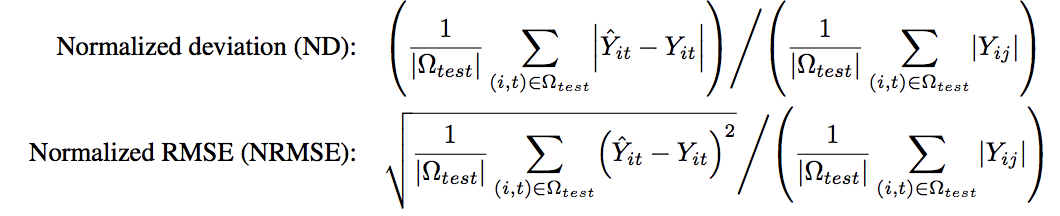

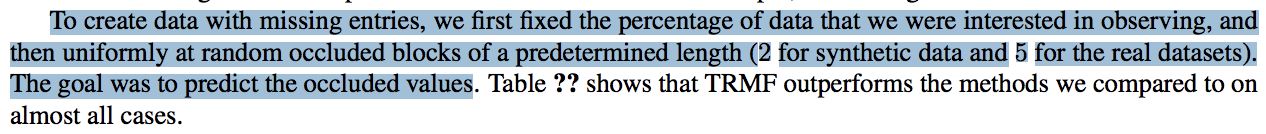

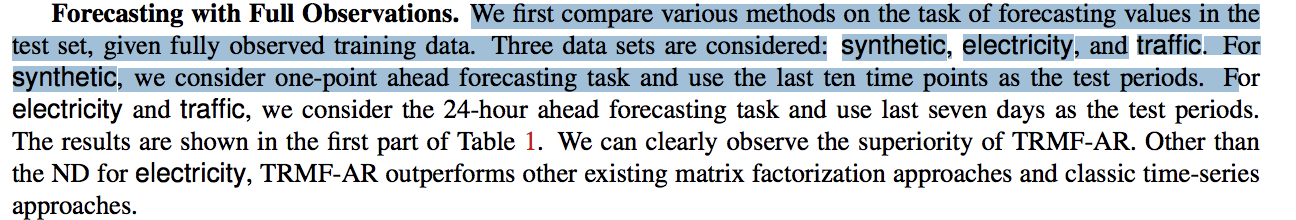

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def norm_mae(y_true, y_pred, indces=None):
    return mean_absolute_error(y_true, y_pred) / abs(y_true).mean()

def norm_rmse(y_true, y_pred, indces=None):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / abs(y_true).mean()

### Factorizing the synthetic dataset

Split the synthetic data into train and test periods

In [ ]:
from sklearn.model_selection import train_test_split

train_targets, test_targets = train_test_split(targets, test_size=.25, shuffle=False)

Never forget to centre and scale the train dataset!

In [ ]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler(with_mean=True, with_std=True)
train_targets_scaled = scl.fit_transform(train_targets)

In [ ]:
if True:
    YY = sp.random(*train_targets.shape, density=1.0,  # 0.52,
                   format="csr", random_state=42)

    YY.data = train_targets_scaled[YY.nonzero()]
else:
    YY = train_targets_scaled.copy()

In [ ]:
# assert np.allclose(YY.toarray(), train_targets_scaled)
YY

Let's fit a model with more factors but the same AR$(p)$ latent process.

In [ ]:
n_order = 12
n_components = 10

In [ ]:
C_Z, C_F, C_phi = 5e-1, 5e-4, 1e-6
eta_Z, eta_F, adj = 0.9995, 0.0, None
fit_intercept = False

f_step_kind = "tron"
n_max_mf_iter = 10

RUN!

In [ ]:
from trmf import TRMFRegressor

In [ ]:
regressor = TRMFRegressor(
    n_components, n_order, C_Z=C_Z, C_F=C_F, C_phi=C_phi,
    eta_Z=eta_Z, eta_F=eta_F, adj=adj, C_B=0.,
    fit_regression=False, fit_intercept=fit_intercept,
    nonnegative_factors=False, n_max_mf_iter=n_max_mf_iter,
    random_state=12)

In [ ]:
regressor.fit(train_targets_scaled)

In [ ]:
get_objective_components(train_targets_scaled, 
                         regressor.factors_,
                         regressor.loadings_,
                         regressor.ar_coef_, C_Z, C_F, C_phi, eta_Z, eta_F, adj)

In [ ]:
full_results = trmf(
    train_targets_scaled, n_components, n_order, C_Z, C_F, C_phi, eta_Z, eta_F, adj=None,
    n_max_mf_iter=n_max_mf_iter, f_step_kind=f_step_kind, verbose=False, tol=1e-5, random_state=12)

```
iter 000 obj 8.100e+03 loss 5.793e-05 Z 5.10e-03 F 2.25e+01 A 3.00e-01 lip 5.0e+02
iter 005 obj 3.540e+03 loss 6.819e-02 Z 6.71e-03 F 9.70e+00 A 2.31e-01 lip 1.9e+02
iter 010 obj 5.322e+02 loss 5.491e-02 Z 1.73e-02 F 1.37e+00 A 2.31e-01 lip 7.4e+01
iter 015 obj 1.066e+02 loss 5.500e-02 Z 2.49e-01 F 1.61e-01 A 1.04e-01 lip 1.1e+02
iter 020 obj 1.063e+02 loss 5.528e-02 Z 2.49e-01 F 1.60e-01 A 1.04e-01 lip 1.8e+02
iter 025 obj 1.063e+02 loss 5.527e-02 Z 2.49e-01 F 1.60e-01 A 1.04e-01 lip 6.8e+01
```

In [ ]:
get_objective_components(train_targets_scaled, *full_results, C_Z, C_F, C_phi, eta_Z, eta_F, adj)

In [ ]:
dense_results = trmf(
    YY.toarray(), n_components, n_order, C_Z, C_F, C_phi, eta_Z, eta_F, adj=None,
    n_max_mf_iter=n_max_mf_iter, f_step_kind=f_step_kind, verbose=False, tol=1e-5, random_state=12)

In [ ]:
get_objective_components(YY.toarray(), *dense_results, C_Z, C_F, C_phi, eta_Z, eta_F, adj)

In [ ]:
regressor.fit(YY.toarray())

In [ ]:
get_objective_components(YY.toarray(), 
                         regressor.factors_,
                         regressor.loadings_,
                         regressor.ar_coef_, C_Z, C_F, C_phi, eta_Z, eta_F, adj)

In [ ]:
regressor.fit(YY)

In [ ]:
get_objective_components(YY, 
                         regressor.factors_,
                         regressor.loadings_,
                         regressor.ar_coef_, C_Z, C_F, C_phi, eta_Z, eta_F, adj)

In [ ]:
sparse_results = trmf(
    YY, n_components, n_order, C_Z, C_F, C_phi, eta_Z, eta_F, adj=None,
    n_max_mf_iter=n_max_mf_iter, f_step_kind=f_step_kind, verbose=False, tol=1e-5, random_state=12)

In [ ]:
get_objective_components(YY, *sparse_results, C_Z, C_F, C_phi, eta_Z, eta_F, adj)

Forecast the latent factors and paste them with the ones inferred from the train.

In [ ]:
train_factors, loadings, ar_coef = full_results
train_factors, loadings, ar_coef = dense_results
train_factors, loadings, ar_coef = sparse_results

In [ ]:
n_ahead, n_horizon = len(test_targets), 1  # 24

forecast_factors = trmf_forecast_factors(
    n_ahead + n_horizon, ar_coef, train_factors)

# paste the train estimates to the prehistory and the dynamic forecast
factors = np.concatenate([train_factors, forecast_factors], axis=0)

Compute the predictions:
$$ 
    \hat{Y}_{t+h\mid t}
        = \hat{X}_{t+h\mid t} F
    \,,\quad
    \hat{X}_{t+h\mid t}
        = \sum_{k=1}^p \mathop{\text{diag}}\bigl(\hat{\phi}_{\cdot k}\bigr) \hat{X}_{t+h-k\mid t}
    \,. $$

In [ ]:
predicted_target = scl.inverse_transform(np.dot(factors, loadings))

<br>

In [ ]:
"""cyka ryba pizdos!!!"""  # a wise man once said...

<br>

### Analysis

Plot the dynamics of the latent factors

In [ ]:
n_cols = 3
n_rows = (n_components + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 1.5*n_rows),
                         sharex=True, sharey=False)

for j, ax in zip(range(n_components), axes.flat):
    ax.plot(factors[:-(n_ahead + n_horizon), j], lw=2)
    ax.plot(factors[:-n_horizon, j], zorder=-1)
    ax.plot(factors[:, j], zorder=-2, alpha=0.5)

for ax in axes.flat[n_components:]:
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.plot([0, len(factors)], [y_min, y_max], c="k", lw=2, alpha=.25)
    ax.plot([0, len(factors)], [y_max, y_min], c="k", lw=2, alpha=.25)

plt.show()
plt.close()

Metrics

In [ ]:
from sklearn.metrics import mean_squared_error

train_predicted_target = predicted_target[:-n_ahead-n_horizon:]

trmf_mse = mean_squared_error(train_targets, train_predicted_target)
trmf_nd = norm_mae(train_targets, train_predicted_target)
trmf_nrmse = norm_rmse(train_targets, train_predicted_target)

lastknown_mse = mean_squared_error(train_targets[1:], train_targets[:-1])
lastknown_nd = norm_mae(train_targets[1:], train_targets[:-1])
lastknown_nrmse = norm_rmse(train_targets[1:], train_targets[:-1])


print(f"""train >>>
TRMF: {trmf_mse:4.3f} {trmf_nd:4.3f} / {trmf_nrmse:4.3f}
Running Last: {lastknown_mse:4.3f} {lastknown_nd:4.3f} / {lastknown_nrmse:4.3f}""")

In [ ]:
from sklearn.metrics import mean_squared_error

test_predicted_target = predicted_target[-n_ahead-n_horizon:-n_horizon]

trmf_mse = mean_squared_error(test_targets, test_predicted_target)
trmf_nd = norm_mae(test_targets, test_predicted_target)
trmf_nrmse = norm_rmse(test_targets, test_predicted_target)

last_mse = mean_squared_error(test_targets, train_targets[[-1] * len(test_targets)])
last_nd = norm_mae(test_targets, train_targets[[-1] * len(test_targets)])
last_nrmse = norm_rmse(test_targets, train_targets[[-1] * len(test_targets)])

lastknown_mse = mean_squared_error(test_targets[1:], test_targets[:-1])
lastknown_nd = norm_mae(test_targets[1:], test_targets[:-1])
lastknown_nrmse = norm_rmse(test_targets[1:], test_targets[:-1])


print(f"""test >>>
TRMF: {trmf_mse:4.3f} {trmf_nd:4.3f} / {trmf_nrmse:4.3f}
Last train: {last_mse:4.3f} {last_nd:4.3f} / {last_nrmse:4.3f}
Running Last: {lastknown_mse:4.3f} {lastknown_nd:4.3f} / {lastknown_nrmse:4.3f}""")

In [ ]:
n_cols = 4
n_rows = (n_targets + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 1.5 * n_rows),
                         sharex=True, sharey=False)

for j, ax in zip(range(n_targets), axes.flat):
    ax.plot(targets[:, j], lw=2)
    ax.plot(predicted_target[:, j], zorder=2)
    ax.axvspan(0, len(train_targets) - 1, color="k", zorder=-1, alpha=0.05)
    ax.set_title(f"""target {j}""")

for ax in axes.flat[n_targets:]:
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.plot([0, len(predicted_target)], [y_min, y_max], c="k", lw=2, alpha=.25)
    ax.plot([0, len(predicted_target)], [y_max, y_min], c="k", lw=2, alpha=.25)
#     ax.set_frame_on(False) ; ax.set_xticks([]) ; ax.set_yticks([])

plt.tight_layout()
plt.show()

In fact the model will be reestimated upon arrival of new data, so
this validation strategy, where we compare dynamic forecasts with
the actual data is incompatible with the usage scenario.

In [ ]:
loadings

In [ ]:
ar_coef

<br>

In [ ]:
assert False, """STOP!"""

## Applying to a real dataset

### Load the demand and relationship data

In [ ]:
import os
BASE_PATH = "/Users/ivannazarov/Bitbox/phd_research/"\
            "finished_side_rivera_huawei_demand/stage1"

In [ ]:
df_demand = pd.read_csv(os.path.join(BASE_PATH, "./data/demand_out_encode_v2.csv"), header=0, index_col=None)
df_demand = df_demand.set_index(["item_code", "rpd", "future_flag"]).sort_index()

In [ ]:
df_topoout = pd.read_csv(os.path.join(BASE_PATH, "./data/topo_out_encode_v2.csv"), header=0, index_col=None)
df_topoout = df_topoout.set_index(["item_code", "rpd", "future_flag", "parent_item_code"]).sort_index()

The list of facts about the dataset:

1. in `demand` and in `topoout` the `quantity` increases as the `future_flag` **decreases from 3 to 0**

2. in `topoout` the `parent_quantity` increases as the `future_flag` **decreases from 3 to 0**

3. in `topoout` the `parent_quantity` is always **less than or equal to** `quantity`

4. the `parent_item_code` in `topoout` is a decomposition: **summing `quantity` in `topoout` over the `parent_item_code`** recovers the respective `quantity` in `demand`

Let $q^f_t$ denote the (vector) total quantity to be delivered by the end of month $t$
though orders made $f$ months in advance.

In [ ]:
demand_total = df_demand["quantity"].unstack(fill_value=0)

* we have $q^{f-1}_t \geq q^f_t$ for all $f$ and $t$
* in general $q^f_t = \delta^f_t + \delta^{f+1}_t + \ldots$, where $\delta^f_t\geq 0$ is the extra quantity ordered to be delivered by $t$ at $t-f$.

In [ ]:
# `periods=-1` shifts the values so that value at `j` becomes the value@`j-1`
demand_delta = demand_total - demand_total.shift(periods=-1, axis=1).fillna(0.)

Thus $q^f_t$ is a forward-looking quantity, which is known by the end of month $t-f$.

* It might be a good predictor of $q^{f-1}_t$

In [ ]:
parent_qty_total = df_topoout["parent_quantity"].unstack("future_flag", fill_value=0)
parent_qty_delta = parent_qty_total - parent_qty_total.shift(periods=-1, axis=1).fillna(0.)

In [ ]:
qty_total = df_topoout["quantity"].unstack("future_flag", fill_value=0)
qty_delta = qty_total - qty_total.shift(periods=-1, axis=1).fillna(0.)

In [ ]:
assert (qty_delta - parent_qty_delta >= 0).all().all()

In [ ]:
df = demand_total[0].unstack("item_code", fill_value=0.)

In [ ]:
# df.to_csv("./dataset.csv")

# df = pd.read_csv("./dataset.csv", header=0, index_col=0)

let's pick a small set of items to use.

In [ ]:
# df = df.sample(n=32, axis=1)

<br>

In [ ]:
from sklearn.model_selection import train_test_split

train_targets, test_targets = train_test_split(df.values, test_size=8, shuffle=False)

In [ ]:
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline


x_form = Pipeline([
    ("log1p", FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=False, check_inverse=False)),
    ("scale", StandardScaler()),
])

In [ ]:
train_demand_scaled = x_form.fit_transform(train_targets)

In [ ]:
n_order, n_components = 3, 20

C_Z, C_F, C_phi = 5e-1, 1e0, 1e-4
eta_Z, eta_F, adj = 0.80, 0.0, None
fit_intercept = False

In [ ]:
n_order, n_components = 3, 20

C_Z, C_F, C_phi = 1e-2, 1e1, 1e-2
eta_Z, eta_F, adj = 0.95, 0.0, None
fit_intercept = False

In [ ]:
train_factors, loadings, ar_coef = trmf(
    train_demand_scaled, n_components, n_order,
    C_Z, C_F, C_phi, eta_Z, eta_F, adj,
    n_max_mf_iter=50, f_step_kind="fgm", verbose=True, tol=1e-4)

In [ ]:
est_roots = np.round(np.stack([np.roots(np.r_[1, -phi[::-1]]) for phi in ar_coef], axis=0), 2)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="polar")
ax.scatter(np.angle(est_roots), np.abs(est_roots), s=50)  #, c=colors, s=area, cmap='hsv', alpha=0.75)
ax.set_rlim(0, 1.5)
plt.show()

In [ ]:
get_objective_components(
    train_demand_scaled, train_factors, loadings, ar_coef,
    C_Z, C_F, C_phi, eta_Z, eta_F, adj)

In [ ]:
n_ahead, n_horizon = len(test_targets), 12

forecast_factors = trmf_forecast_factors(
    n_ahead + n_horizon, ar_coef, train_factors)

# paste the train estimates to the prehistory and the dynamic forecast
factors = np.concatenate([train_factors, forecast_factors], axis=0)

In [ ]:
predicted_demand = x_form.inverse_transform(np.dot(factors, loadings))

In [ ]:
n_cols = 3
n_rows = (n_components + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 1.5*n_rows),
                         sharex=True, sharey=False)

for j, ax in zip(range(n_components), axes.flat):
    ax.plot(factors[:-(n_ahead + n_horizon), j], lw=2)
    ax.plot(factors[:-n_horizon, j], zorder=-1)
    ax.plot(factors[:, j], zorder=-2, alpha=0.5)
#     ax.plot(factors[:-48, j], zorder=-1)
#     ax.plot(factors[:, j], zorder=-2, alpha=0.5)

for ax in axes.flat[n_components:]:
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.plot([0, len(factors)], [y_min, y_max], c="k", lw=2, alpha=.25)
    ax.plot([0, len(factors)], [y_max, y_min], c="k", lw=2, alpha=.25)

plt.show()
plt.close()

Metrics

In [ ]:
from sklearn.metrics import mean_squared_log_error

train_predicted_target = predicted_demand[:-n_ahead-n_horizon]

trmf_mse = mean_squared_error(train_targets, train_predicted_target)
lastknown_mse = mean_squared_error(train_targets[1:], train_targets[:-1])


print(f"""train >>>\nTRMF: {trmf_mse}\nRunning Last: {lastknown_mse}""")

In [ ]:
test_predicted_target = predicted_demand[-n_ahead-n_horizon:-n_horizon]

trmf_mse = mean_squared_error(test_targets, test_predicted_target)
last_mse = mean_squared_error(test_targets, train_targets[[-1] * len(test_targets)])
lastknown_mse = mean_squared_error(test_targets[1:], test_targets[:-1])


print(f"""test >>>\nTRMF: {trmf_mse}\nLast train: {last_mse}\nRunning Last: {lastknown_mse}""")

In [ ]:
n_targets = df.values.shape[1]
for j in range(min(n_targets, 12)):
    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(111, title=f"""target {j}""")
    ax.plot(df.values[:, j], lw=2)
    ax.plot(predicted_demand[:, j], zorder=2)
    ax.axvspan(0, len(train_targets) - 1, color="k", zorder=-1, alpha=0.05)

    plt.tight_layout()
    plt.show()
    plt.close()

<br>

In [ ]:
assert False, """Do not run!"""

n_targets = df.values.shape[1]
n_cols = 4
n_rows = (n_targets + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 1.5 * n_rows),
                         sharex=True, sharey=False)

for j, ax in zip(range(n_targets), axes.flat):
    ax.plot(df.values[:, j], lw=2)
    ax.plot(predicted_demand[:, j], zorder=2)
    ax.axvspan(0, len(train_targets) - 1, color="k", zorder=-1, alpha=0.05)
    ax.set_title(f"""target {j}""")

for ax in axes.flat[n_targets:]:
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.plot([0, len(predicted_demand)], [y_min, y_max], c="k", lw=2, alpha=.25)
    ax.plot([0, len(predicted_demand)], [y_max, y_min], c="k", lw=2, alpha=.25)
#     ax.set_frame_on(False) ; ax.set_xticks([]) ; ax.set_yticks([])

plt.tight_layout()
plt.show()

<br>

In [ ]:
assert False, """STOP!"""

<br>

Gramm-Schmidt ftw!
$$
    f_k = g_k - \sum_{i=1}^{k-1} \langle g_k, u_i \rangle u_i
    \,,\quad u_k = \tfrac{f_k}{\|f_k\|_2}
    \,. $$
$$
    f_k = (I - U_{:k} U_{:k}^{\mathrm{T}}) g_k
    \,. $$

In [ ]:
G = random_state.normal(size=(250, 25))

U = np.zeros_like(G)
for k in range(G.shape[1]):
    f_k = G[:, k] - np.dot(U[:, :k], np.dot(U[:, :k].T, G[:, k]))
    U[:, k] = f_k / np.linalg.norm(f_k, ord=2)

In [ ]:
@nb.njit("float64[:, ::1](float64[:, ::1], int64)",
         fastmath=True, cache=False, error_model="numpy")
def gramm_schmidt(G, start):
    for k in range(start, min(*G.shape)):
        alpha = np.dot(G[:, :k].T, G[:, k])
        G[:, k] -= np.dot(G[:, :k], alpha)
        G[:, k] /= np.linalg.norm(G[:, k], 2)
    return G

In [ ]:
G = random_state.normal(size=(250, 250))
G = gramm_schmidt(G, 0)

assert np.allclose(np.dot(G.T, G), np.eye(*G.shape))
assert np.allclose(np.dot(G, G.T), np.eye(*G.shape))

In [ ]:
assert False, """STOP!"""

<br>

In [ ]:
# np.median(abs((scl.inverse_transform(np.dot(X, F)) - df.values) / np.maximum(df.values, 1)))

In [ ]:
np.linalg.norm(ar_resid(X, phi), ord=2, axis=0)**2

In [ ]:
abs(np.stack([np.roots(np.r_[1, -phi[j]]) for j in range(n_components)], axis=0))

In [ ]:
(F==0).mean(axis=0)

In [ ]:
loadings

In [ ]:
plt.plot(F.T, c="red")
plt.plot(loadings.T, c="black")

<br>

### Trunk

Notice that
\begin{equation}
\tfrac{\eta}2 \|X\|^2
    = \sum_{j=1}^d \tfrac{\eta}2 \|X e_j\|^2
    = \sum_{j=1}^d \tfrac{\eta}2 (X e_j)^{\mathrm{T}} (X e_j)
    \,,
\end{equation}
whence
\begin{align}
\tfrac12 \sum_{j=1}^d \lambda_j
    \sum_{t=p+1}^T \bigl(
        X_{tj} - \sum_{k=1}^p \phi_{jk} X_{t-k,j}
    \bigr)^2
    + \tfrac{\eta}2 \|X\|^2
    &= 
    \tfrac12 \sum_{j=1}^d \lambda_j
        e_j^{\mathrm{T}} X^{\mathrm{T}} (A(\phi_j) + \eta I) X e_j
    \,,
\end{align}
where $A(\phi_j)$ is the AR-regularizer matrix computed for $\beta = \phi_j = e_j^{\mathrm{T}} \phi$.

The objective in the $X$-step is
\begin{align}
Q(X \mid F, \phi)
    &= \tfrac12 \|Y - X F\|^2
    + \tfrac12 \sum_{j=1}^d \lambda_j
        \sum_{t=p+1}^T \bigl(
            X_{tj} - \sum_{k=1}^p \phi_{jk} X_{t-k,j}
        \bigr)^2
    + \tfrac{\eta}2 \|X\|^2
    \\
    &= \tfrac12 \|Y - X F\|^2
    + \tfrac12 \sum_{j=1}^d
        e_j^{\mathrm{T}} X^{\mathrm{T}} (\lambda_j A(\phi_j) + \eta I) X e_j
    \\
    &= \tfrac12 \Bigl\|
        \underbrace{
            \Bigl(Y - \sum_{k\neq j} X e_k e_k^{\mathrm{T}} F\Bigr)
        }_{R_{-j}} - X e_j e_j^{\mathrm{T}} F \Bigr\|^2
    + \tfrac12 \sum_{j=1}^d
        e_j^{\mathrm{T}} X^{\mathrm{T}} (\lambda_j A(\phi_j) + \eta I) X e_j
    \\
    &= \tfrac12 \bigl\| R_{-j} - z_j F_j^{\mathrm{T}} \bigr\|^2
    + \tfrac12 z_j^{\mathrm{T}} (\lambda_j A(\phi_j) + \eta I) z_j
    + \tfrac12 \sum_{k\neq j}
        e_k^{\mathrm{T}} X^{\mathrm{T}} (\lambda_k A(\phi_k) + \eta I) X e_k
      \,,
\end{align}
where $z_j = X e_j \in \mathbb{R}^{T\times 1}$ and $F_j = e_j^{\mathrm{T}} F \in  \mathbb{R}^{n \times 1}$.

Notice, that the $j$-th factor is the result of a regularized rank-1 approximation of $R_{-j}$.

Therefore the optimization subproblem for the $j$-th factor conditional on
$(F, \phi)$ and all other factos (through the residual $R_{-j}$) is
\begin{equation}
\begin{aligned}
    & \underset{z \,\mid\, F, \phi}{\text{minimize}}
      & & Q_j(z\mid F, \phi)
          = \tfrac12 \bigl\| R_{-j} - z F_j^{\mathrm{T}} \bigr\|^2
          + \tfrac12 \lambda_j
              z^{\mathrm{T}} (A(\phi_j) + \eta I) z
          \,.
\end{aligned}
\end{equation}

The gradient of the objective is
\begin{equation}
\nabla Q_j(z \mid F, \phi)
    = - (R_{-j} - z F_j^{\mathrm{T}}) F_j
    + (\lambda_j A(\phi_j) + \eta I) z
    \,.
\end{equation}

<br>

Using the time series autoregressive embedding of order $p$ this problem
becomes the familiar ridge regresssion:
\begin{equation}
\begin{aligned}
    & \underset{\beta}{\text{minimize}}
      & & \tfrac12 \|y_{p+1:} - Z \beta \|^2
          + \tfrac{C}2 \|\beta \|^2
          \,.
\end{aligned}
\end{equation}
where $Z_t = (y_{t-k})_{k=1}^p \in \mathbb{R}^{p\times 1}$ and $Z \in \mathbb{R}^{t-p \times p}$.
The final $Z$ looks like $(y_{s:T-p+s})_{s=1}^p$ with $y_{s:t} = (y_\tau)_{s \leq \tau < t}$.

\begin{equation}
\begin{aligned}
    & \underset{X\mid\, F, \phi}{\text{minimize}}
      & & \tfrac12 \|Y - X F\|^2
          + \tfrac12 \sum_{j=1}^d \lambda_j
              \sum_{t=p+1}^T \bigl(
                  X_{tj} - \sum_{k=1}^p \phi_{jk} X_{t-k,j}
              \bigr)^2
          + \tfrac{\eta}2 \|X\|^2
          \,.
\end{aligned}
\end{equation}

Let $L^p_k$ be a rectangular matrix $T-p \times T$ given by
\begin{equation}
    L^p_k = \begin{pmatrix}
        \underbrace{0}_{p-k} & \underbrace{I}_{T-p} & \underbrace{0}_{k}
    \end{pmatrix}
    \,.
\end{equation}
Then for any $k$ we have $L^p_k Z = (Z_s)_{s=1+p-k}^{T-k}$, meaing that $L^p_k$
represents the matrix instance of the lag operator.

Hence,
\begin{equation}
    \bigl(X_{tj} - \sum_{k=1}^p \phi_{jk} X_{t-k,j}\bigr)_{t=1+p}^T
        = L^P_0 X e_j - \sum_{k=1}^p L^P_k X e_j \phi_{jk}
\end{equation}

**Note** The optimal $\phi$ depends only on $X$. So, we may actually group the $X$- and $\phi$ steps together.

### The joint step (rewrite)

Now we observe that conditional on $X$ the problem splits into independent subproblems:
one w.r.t. $F$ and another w.r.t $\phi$.

The subproblems can be solved simultaneously, but by different methods.

The $\phi$-subproblem admits a closed form solution given by the ridge-regression estimate of $\phi$.

This is not the case in$F$-subrpoblem due to the nonnegativity constraint.

<br>

**THIS no longer holds**
Due to the graph regularizer, the targets are now tied together, so
the following is for illustrative purposes only.

First, notice that unless $\eta_F > 0$, the $F$-subproblem decomposes into $n$ simpler
problems all of the form
$$
    \min_{\beta\geq 0}
        \tfrac1{2 T n} \| y - X \beta\|^2_2 + \tfrac{\lambda_F}{2 d n} \|\beta\|^2
\,, $$
for some time-series $y \in \mathbb{R}^{T\times 1}$ and factors $X$. For instance, $y = Y e_j$
and $\beta = F e_j$ recover the $j$-th subproblem, which when stacked, result in
the complete $F$-step problem.

##### The ADMM-type algorithm for the $F$-step.

The FOC in subdifferential form are
$$
    % 0 \in - X^{\mathrm{T}} (y - X \beta) + C \beta + \partial \iota_{\mathbb{R}^d_+}(\beta)
    X^{\mathrm{T}}y \in
        \bigl(X^{\mathrm{T}} X + C I \bigr) \beta + \partial \iota_{\mathbb{R}^d_+}(\beta)
    \,. $$

$$
    L = \tfrac12 \| y - X \beta\|^2_2 + \tfrac{\lambda_F T}{2 d} \|\beta\|^2
    + \iota_{\mathbb{R}^d_+}(\zeta)
    % + \tfrac1{2 \nu}\|\beta - \zeta\|^2
    % + \tfrac1{\nu} \mu^{\mathrm{T}} (\beta - \zeta)
    + \tfrac1{2 \nu}\|\beta - \zeta + \mu\|^2
    - \tfrac1{2 \nu} \|\mu\|^2
    \,. $$    

* $(X'X + \tfrac{\lambda_F T}{d} + \tfrac1\nu) \beta_{t+1} = X'y + \zeta_t - \mu_t$
\begin{align}
    \beta_{t+1}
        &= \arg \min_\beta
            \tfrac12 \| y - X \beta\|^2_2 + \tfrac{\lambda_F T}{2 d} \|\beta\|^2
            + \tfrac1{2\nu}\|\beta - (\zeta_t - \mu_t) \|^2
        \,, \\
    \zeta_{t+1}
        & = \arg \min_\zeta
            \iota_{\mathbb{R}^d_+}(\zeta) + \tfrac1{2\nu}\|\zeta - (\beta_{t+1} + \mu_t)\|^2
        \\
        &= {\text{prox}}_{\eta \iota_{\mathbb{R}^d_+}} (\mu_t + \beta_{t+1})
            = (\beta_{t+1} + \mu_t)_+
        \,, \\
     \mu_{t+1}
         &= \mu_t + \beta_{t+1} - \zeta_{t+1}
         \,,
\end{align}

The FOC in subdifferential form are
$$
    x \in z + \nu \partial \iota_{\mathbb{R}^d_+}(z)
    \Leftrightarrow
    z = (\mathrm{id} + \nu \partial \iota_{\mathbb{R}^d_+})^{-1}(x)
    \,. $$

The subdifferential of $\iota_{\mathbb{R}^d_+}$ at $z$ is
$$
\partial \iota_{\mathbb{R}^d_+}(z)
    = \{p\colon 0 \geq p'(y-z)\, \forall y\geq 0 \}
    \,. $$

Solving all this is hard, so solving the optimization problem directly yields
$$
{\text{prox}}_{\eta \iota_{\mathbb{R}^d_+}}(x)
    = (\max\{x_i, 0\})_{i=1}^n
\,. $$

<br>

### Loading the relationship data

Gather all `topoout['item_code'] -> topoout['parent_item_code']` pairs loaded with the associated quantities.

In [ ]:
edges = {}
for (itm, rpd, f_f, par), (qty, par_qty) in tqdm.tqdm(df_topoout.iterrows()):
    edges.setdefault((rpd, f_f), []).append((itm, par, {"qty": qty, "par": par_qty}))

Create the graph all edges that were every encoutedet (**including the test period!**)

In [ ]:
import networkx as nx

master = nx.from_edgelist(((u, v) for lst in edges.values() for u, v, _ in lst), create_using=nx.DiGraph)

Create `index` to `vertex` bijection (`vertex` = `item_code`)

In [ ]:
itov = dict(enumerate(master))
vtoi = dict(zip(itov.values(), itov.keys()))

assert len(itov) == len(vtoi)

Most functions in nx traverse the graph in the order of `G.nodes()`,
which is equivalent to iterating over `G`:
> If your node data is not needed, it is simpler and equivalent 
to use the expression ``for n in G``, or ``list(G)``.

Create a 2D geometric layout for the undirected version of the graph

In [ ]:
import os, pickle, gzip

if os.path.exists("./master_pos.gz"):
    with gzip.open("./master_pos.gz", "r") as fin:
        master_pos = pickle.load(fin)
else:
    master_pos = nx.layout.kamada_kawai_layout(nx.Graph(master), scale=10)
    with gzip.open("./master_pos.gz", "w", compresslevel=9) as fout:
        pickle.dump(master_pos, fout)

Do a toposort on the master graph

In [ ]:
accumulated_stock = (
    qty_delta - parent_qty_delta
).sum(level=["item_code", "rpd"])
df_stock = accumulated_stock.sort_index().groupby(["item_code"]).cumsum()

In [ ]:
nbunch = pd.unique(df_stock.index.get_level_values("item_code"))
items = list(nx.topological_sort(nx.subgraph(master, nbunch)))

In [ ]:
transitory, source, sink = [], [], []
for item in items:
    if not master.pred[item]:
        source.append(item)
    elif not master.succ[item]:
        sink.append(item)
    else:
        transitory.append(item)
    # end if
# end for


In [ ]:
items = source + transitory + sink

In [ ]:
assert False, """STOP!"""

In [ ]:
from math import sqrt, floor, ceil

n_plots, aspect = len(items), (4, 3)

n_rows = round(sqrt(aspect[1] * float(n_plots) / aspect[0])+0.15)
n_cols = round(sqrt(aspect[0] * float(n_plots) / aspect[1])+0.15)

coef_w, coef_h = 3, 2

figsize = n_cols * coef_w, n_rows * coef_h

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False,
                         sharex=True, sharey=False,
                         figsize=figsize, facecolor="white", dpi=320)

# reset all axes
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# plot the datasets
for item_code, ax in tqdm.tqdm(zip(items, axes.flat)):
    ax.plot(df_stock.loc[item_code])
    if not master.pred[item_code]:
        fmt = "item_code {}->"
    elif not master.succ[item_code]:
        fmt = "item_code ->{}"
    else:
        fmt = "item_code {}"

    ax.set_title(fmt.format(item_code))
    ax.set_frame_on(True)

# plot unused fillers
for ax in axes.flat[n_plots:]:
#     ax.plot([0, 1], [0, 1], color="black", alpha=0.25, lw=2)
#     ax.plot([1, 0], [0, 1], color="black", alpha=0.25, lw=2)
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
    pass

fig.tight_layout()

fig.savefig("./all_toposort_stock.pdf")
plt.close()

Make a copy of the master graph

In [ ]:
G_demand = master.copy()

Attach the true demand data to each node in the `mater` graph.

In [ ]:
ic_demand = demand_delta.groupby(level="item_code")

values = {ic: df.loc[ic] for ic, df in ic_demand}
nx.set_node_attributes(G_demand, values, "delta")

Get a view into the node data

In [ ]:
data = G_demand.nodes("delta", default=None)

Create neighbour-based features

In [ ]:
features = {}
for v in tqdm.tqdm(G_demand):
    features.setdefault(v, {})

#### Upstream

In [ ]:
for v in tqdm.tqdm(G_demand):
    upstream = {u: data[u] for u in G_demand.succ[v]}
    # upstream.update({v: data[v].iloc[:0]})
    if not upstream:
        continue
    df = pd.concat(upstream, axis=0)

    features[v].update({
        ("upstream", "avg"): df.mean(level="rpd", axis=0),
        ("upstream", "max"): df.max(level="rpd", axis=0),
        ("upstream", "std"): df.std(level="rpd", axis=0).fillna(1.)
    })

#### Downstream

In [ ]:
for v in tqdm.tqdm(G_demand):
    downstream = {u: data[u] for u in G_demand.pred[v]}
    # downstream.update({v: data[v].iloc[:0]})
    if not downstream:
        continue

    df = pd.concat(downstream, axis=0) 
    features[v].update({
        ("downstream", "avg"): df.mean(level="rpd", axis=0),
        ("downstream", "max"): df.max(level="rpd", axis=0), 
        ("downstream", "std"): df.std(level="rpd", axis=0).fillna(1.)
    })

Gather features in dataframes

In [ ]:
data = {k: pd.concat(v, axis=1, names=["group", "feature"])
        for k, v in tqdm.tqdm(features.items())}

Attach to graph nodes

In [ ]:
nx.set_node_attributes(G_demand, data, "features")

In [ ]:
assert False, """STOP!"""

<br>

Put everything into a collection of graphs indexed by `(requested package date, future_flag)`

In [ ]:
graphs = {key: nx.from_edgelist(lst, create_using=nx.DiGraph) for key, lst in edges.items()}

<br>

Setup the data geometry of the canvas

In [ ]:
def _infalte(a, b, rtol=1e-1, atol=1e-2):
    return a - np.maximum(abs(a), 1.) * rtol - atol, b + np.maximum(abs(b), 1.) * rtol + atol

coord = np.stack(master_pos.values(), axis=0)
c_min, c_max = _infalte(coord.min(axis=0), coord.max(axis=0))

Plot!

In [ ]:
rpd = 1

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111,
                     xlim=(c_min[0], c_max[0]),
                     ylim=(c_min[1], c_max[1]))

nodes = set()
for ff, col in zip([0, 1, 2, 3], ["C0", "C1", "C2", "C3"]):
    G = graphs[rpd, ff]
    nodes.update(G)
    nx.draw_networkx_edges(G, pos=master_pos, ax=ax, edge_color=col,
                           alpha=0.25, width=2.0, zorder=+12)

xx, yy = zip(*[master_pos[v] for v in nodes])
ax.scatter(xx, yy, s=5, color="blue", zorder=-12, alpha=1.0)

plt.show()
plt.close()

<br>

In [ ]:
demand_delta_skewed = pd.concat({
    item_code: pd.concat([df.loc[item_code][s].shift(periods=-s) for s in [0, 1, 2, 3]], axis=1)
    for item_code, df in demand_delta.groupby("item_code")
}, names=["item_code"], axis=0)

## Machine learning

Collect the data from all nodes

In [ ]:
df = pd.concat(dict(G_demand.nodes("features")), names=["item_code"], axis=1)

Get the average features for `ff=0`

In [ ]:
df

In [ ]:
df.xs(["avg", 0], level=["feature", "future_flag"], axis=1)

<br>

## Create a dataset for autoregression

Let's fix the `future_flag` at `0`:

In [ ]:
df_ff0 = demand_delta[0].unstack("item_code", fill_value=0)

df_ff0.head()

However, although the `item_code` corresponds to the `vertex` in the master graph, the matrices
produced by `networkx` are **indexed** by the **insertion order** of the vertices in the graph.

In [ ]:
df_ff0.rename(columns=vtoi).head()

A an all-in-one transformer for the dataframes indexed by `item_code`!

In [ ]:
from sklearn.utils.extmath import safe_sparse_dot

def df_right_matmul(data, matrix):
    # item_code -> natual number + sort
    df = data.rename(columns=vtoi).sort_index(axis=1)

    # right-hand matmul
    df = pd.DataFrame(safe_sparse_dot(df.values, matrix),
                      index=df.index, columns=df.columns)

    # natual number -> item_code + orignal item_code order
    return df.rename(columns=itov).reindex(columns=data.columns)

<br>

The symmetric normalized laplacian matrix is $L = D^{-\tfrac12} \mathcal{L} D^{-\tfrac12}$:
$$ \mathcal{L}
    = \underbrace{\text{diag}(\delta_v)_{v\in G}}_{D} - A
    = \biggl( e_v \lvert G_v \rvert - \sum_{u\in G_v} e_u \biggr)_{v \in G}
\,,\quad \mathcal{L} = \mathcal{L}^{\mathrm{T}} $$
This does this $v\mapsto q_v - \sum_{u \in G_v} \tfrac1{\sqrt{\delta_u \delta_v}} q_u$.

But what we actually need is $L = \mathcal{L} D^{-1}$ (since we will be left-applying the operator).
It would do $v \mapsto q_v - \tfrac1{\delta_v} \sum_{u\in G_v} q_u$, i.e. basically it would take
the value at a node and subtract the average across its neighbours.

\begin{align}
    \bar{q}^{\mathrm{T}} =
    \sum_{v\in G} \Bigl(
        q_v - \tfrac1{\delta_v} \sum_{u\in G_v} q_u
    \Bigr) e_v^{\mathrm{T}}
    &= q^{\mathrm{T}}
        \biggl(
            \sum_{v\in G} \Bigl(
                e_v \delta_v - \sum_{u\in G_v} e_u
            \Bigr) \tfrac1{\delta_v} e_v^{\mathrm{T}}
        \biggr)
    = q^{\mathrm{T}}
        \sum_{p\in G} \biggl(
            \underbrace{
                \sum_{v\in G} \Bigl(
                    e_v \delta_v - \sum_{u\in G_v} e_u
                \Bigr) e_v^{\mathrm{T}}
            }_{D - A}
        \biggr) e_p \tfrac1{\delta_p} e_p^{\mathrm{T}}
    \\
    &= q^{\mathrm{T}} (D - A)
        \sum_{p\in G} e_p \tfrac1{\delta_p} e_p^{\mathrm{T}}
    = q^{\mathrm{T}} (D - A) D^{-1}
\,.
\end{align}

In [ ]:
nx.normalized_laplacian_matrix()

In [ ]:
adj = nx.adjacency_matrix(nx.Graph(master)).astype(float)

In [ ]:
adj.sum(axis=0)

In [ ]:
# the adjacency of the undirected graph `master`
adj = nx.adjacency_matrix(master).astype(float)
degree = np.maximum(adj.sum(axis=0).A1, 1.)

Recall that $v\mapsto G_v$ gives the set nodes that are endpoints of some edge from $v$.
In the particular case of the `item_code - parent_item_code` relation this is the  set
of parents of $v$ in $G$.

The matrix to average across all siblings is based on the following one:
$$ A A^\mathrm{T}
    = \biggl(\sum_{u \in G} \sum_{v \in G_u} e_u e_v^\mathrm{T}\biggr)
        \biggl(\sum_{p \in G} \sum_{q \in G_p} e_q e_p^\mathrm{T}\biggr)
    = \sum_{u, p \in G} e_u \Bigl(
        \sum_{v \in G_u} \sum_{q \in G_p} e_v^\mathrm{T} e_q
    \Bigr) e_p^\mathrm{T}
    = \sum_{u, p \in G} e_u
        \underbrace{\lvert G_u \cap G_p \rvert}_{\text{share the same parent}}
    e_p^\mathrm{T}
    \,. $$

Siblings binary matrix is $S = \mathtt{is-positive} (A A^\mathrm{T}) - I$.

The parents' binary matrix is $P = \mathtt{is-positive} (A^\mathrm{T} A) - I$, since
$$ A^\mathrm{T} A
    = \biggl(\sum_{p \in G} \sum_{q \in G_p} e_q e_p^\mathrm{T}\biggr)
        \biggl(\sum_{u \in G} \sum_{v \in G_u} e_u e_v^\mathrm{T}\biggr)
    = \sum_{q, v \in G} e_q \Bigl(
        \sum_{p\colon q \in G_p} \sum_{u\colon v \in G_u} e_p^\mathrm{T} e_u
    \Bigr) e_v^\mathrm{T}
    = \sum_{q, v \in G} e_q
        \underbrace{\lvert x\colon v, q \in G_x \rvert}_{\text{have common child}}
    e_v^\mathrm{T}
    \,. $$

In [ ]:
AAT = safe_sparse_dot(adj, adj.T, dense_output=True)
ATA = safe_sparse_dot(adj.T, adj, dense_output=True)

In [ ]:
plt.imshow(AAT - np.diag(adj.sum(axis=1).A1))

In [ ]:
plt.imshow(ATA - np.diag(adj.sum(axis=0).A1))

```python
[itov[i] for i in adj_upstream[vtoi[9], :].indices]
```

Get the `upstream` adjacency matrix, which represents `child (rows) -> parent (columns)` relation.

And compute the `upstream averaging` matrix.

In [ ]:
adj_upstream = nx.adjacency_matrix(master)
deg_upstream = adj_upstream.sum(axis=1).A1

avg_upstream = adj_upstream.astype(float, copy=True)
avg_upstream.data /= np.maximum(deg_upstream, 1.)[adj_upstream.indices]

The `downstream` adjacency matrix, representin `parent (rows) -> child (columns)` relation, is just the transposed `upstream` matrix.

And compute the `downstream averaging` matrix.

In [ ]:
adj_downstream = adj_upstream.T.tocsr()
deg_downstream = adj_downstream.sum(axis=1).A1

avg_downstream = adj_downstream.astype(float, copy=True)
avg_downstream.data /= np.maximum(deg_downstream, 1.)[adj_downstream.indices]

Also compute the `upstream / downstream balancing` matrices to get the discrepancy.

In [ ]:
from scipy.sparse import eye

unit_diag = eye(len(master))

balance_ud = (adj_downstream + adj_upstream - 2 * unit_diag).astype(float)

The mean of neighbour values is given by $M = X L$, where $X$ is $\times G$ matrix of values.

In [ ]:
df_ff0_downstream = df_right_matmul(df_ff0, avg_downstream)
df_ff0_downstream.round(2).head()

In [ ]:
df_ff0_upstream = df_right_matmul(df_ff0, avg_upstream)
df_ff0_upstream.round(2).head()

In [ ]:
df_ff0_balance = df_right_matmul(df_ff0, balance_ud)
df_ff0_balance.round(2).head()

In [ ]:
# df_qty = df_demand["quantity"].unstack("future_flag", fill_value=0)
# df_delta = df_qty - df_qty.shift(periods=-1, axis=1).fillna(0.)

In [ ]:
from itertools import product
G = G_demand
for v in G:
    sib = {*chain(*(G.pred[u] for u in G.succ[v]))} - {v}
    # sib = {*chain(*(product((u,), G.pred[u]) for u in G.succ[v]))}

<br>

In [ ]:
item_code = 22

In [ ]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(111, title="For item_code {}".format(item_code))

df_ff0[item_code].plot(ax=ax, label="level")
df_ff0_downstream[item_code].plot(ax=ax, label="downstream")
df_ff0_upstream[item_code].plot(ax=ax, label="upstream")

df_ff0_balance[item_code].plot(ax=ax, label="balance")

ax.legend()

In [ ]:
@nb.njit("float64[:,::1](float64[:,::1], float64[:,::1], "
         "float64[::1], int32[::1], int32[::1])", locals={
             "tmp": nb.float64[::1],
             "out": nb.float64[:, ::1]
         }, fastmath=True, cache=False, error_model="numpy")
def op_s(X, Z, Sx, Sp, Sj):
    # computes S -> X' S Z -- d1 x k dense matrix
    n1, d = X.shape
    n2, k = Z.shape

    out = np.zeros((d, k), dtype=np.float64)
    tmp = np.zeros(k, dtype=np.float64)
    for i in range(n1):
        # get \tau_i = \sum_{j:(i,j)\in \Omega} S_{ij} e_j' Z
        for j in range(Sp[i], Sp[i+1]):
            # tmp += Z[Sj[j]] * Sx[j]
            row, Sij = Z[Sj[j]], Sx[j]
            for t in range(k):
                tmp[t] += row[t] * Sij
        
        # multiply X'e_i \tau_i
        for l in range(d):
            # out[l] += tmp * X[i, l]
            Xil, row = X[i, l], out[l]
            for t in range(k):
                row[t] += tmp[t] * Xil

        tmp[:] = 0
    return out

In [ ]:
@nb.njit("float64[::1](float64[:,::1], float64[:,::1], "
         "float64[:,::1], int32[::1], int32[::1])", locals={
             "tmp": nb.float64[::1],
             "out": nb.float64[::1],
             "val": nb.float64
         }, fastmath=True, cache=False, error_model="numpy")
def op_d(X, Z, D, Sp, Sj):
    # computes D -> X D Z' -- n1 x n2 sparse matrix
    n1, d = X.shape
    n2, k = Z.shape

    out = np.zeros(Sp[n1], dtype=np.float64)
    tmp = np.zeros(k, dtype=np.float64)
    for i in range(n1):
        # compute e_i' XD
        for l in range(d):
            Xil, row = X[i, l], D[l]
            for t in range(k):
                # compute sum_l e_i' X e_l e_l' D e_t
                tmp[t] += row[t] * Xil

        # compute e_i' XD e_t e_t' Z' e_{Sj[j]}
        for j in range(Sp[i], Sp[i+1]):
            # out[j] = np.dot(Z[Sj[j]], tmp)
            row, val = Z[Sj[j]], 0.
            for t in range(k):
                val += row[t] * tmp[t]
            out[j] = val

        tmp[:] = 0
    return out

In [ ]:
@nb.njit("float64[::1](float64[:,::1], float64[:,::1], "
         "int32[::1], int32[::1])", locals={
             "out": nb.float64[::1],
         }, fastmath=True, error_model="numpy", parallel=True, cache=False)
def _op(X, D, Sp, Sj):
    # computes D -> X D -- n1 x n2 sparse matrix
    out = np.zeros(Sp[len(X)], dtype=np.float64) # _like(Sx)  # 
    for i in nb.prange(len(X)):
        for j in range(Sp[i], Sp[i+1]):
            # compute e_i' XD e_{Sj[j]}
            out[j] = np.dot(X[i], D[:, Sj[j]])
#         out[Sp[i]:Sp[i+1]] = np.dot(X[i, :], D[:, Sj[Sp[i]:Sp[i+1]]])
    return out

@nb.njit("(float64[:,::1], float64[:,::1], int32[::1], int32[::1], float64[::1])",
         fastmath=True, error_model="numpy", parallel=True, cache=False)
def _op2(X, D, Sp, Sj, out):
    # computes D -> X D -- n1 x n2 sparse matrix
    for i in nb.prange(len(X)):
        for j in range(Sp[i], Sp[i+1]):
            # compute e_i' XD e_{Sj[j]}
            out[j] = np.dot(X[i], D[:, Sj[j]])
#         out[Sp[i]:Sp[i+1]] = np.dot(X[i, :], D[:, Sj[Sp[i]:Sp[i+1]]])
    # end for
    return

def op(X, D, Y):
    U = Y.copy()
    U.data = _op(X, D, U.indptr, U.indices)
    return U

def op2(X, D, Y):
    U = Y.copy()
    _op2(X, D, U.indptr, U.indices, U.data)
    return U

In [ ]:
from scipy.sparse import csr_matrix, isspmatrix

from sklearn.utils.extmath import safe_sparse_dot


def op_s_ref(R, X, Z, S):
    U = csr_matrix(R, copy=False)
    U.data = S
    return safe_sparse_dot(safe_sparse_dot(X.T, U), Z)


def op_d_ref(R, X, Z, D):
    # ii, jj = R.nonzero()
    # return np.multiply(safe_sparse_dot(X[ii, :], D), Z[jj, :]).sum(axis=1)
    return safe_sparse_dot(safe_sparse_dot(X, D), Z.T)[R.nonzero()]

In [ ]:
n1, n2, d = 10000, 2500, 10

Y = sp.random(n1, n2, density=0.01, format="csr")

Z = random_state.normal(size=(n1, d))
F = random_state.normal(size=(d, n2))


In [ ]:
# block = D[:, Sj[Sp[i]:Sp[i+1]]]
# out[Sp[i]:Sp[i+1]] = np.dot(X[i, :], block)
    
@nb.njit("(float64[:,::1], float64[:,::1], int32[::1], int32[::1], float64[::1])",
         fastmath=True, error_model="numpy", parallel=True, cache=False)
def _op_omega(X, D, Sp, Sj, out):
    # computes D -> X D -- n1 x n2 sparse matrix
    for i in nb.prange(len(X)):
        # compute e_i' XD e_{Sj[j]}
        for j in range(Sp[i], Sp[i+1]):
            out[j] += np.dot(X[i], D[:, Sj[j]])
    # end for
    return


def op_omega(X, D, Y):
    U = csr_zeros_like(Y)
    _op_omega(X, D, U.indptr, U.indices, U.data)
    return U

In [ ]:
# print(list(_op_omega.inspect_llvm().values())[0])

In [ ]:
U = op_omega(Z, F, Y)
assert np.allclose(U.data, np.dot(Z, F)[Y.nonzero()])

In [ ]:
%%timeit -n 100
op_omega(Z, F, Y)

In [ ]:
l2_loss_valj(Y, Z, F)

<br>